In [31]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


sys.path.insert(0, "../../../src")


# Re-format data file


In [32]:
station_names = [
    {
        "Site_Id": 107,
        "SiteName": "LIVERPOOL",
        "Longitude": 150.90727,
        "Latitude": -33.93132,
        "Region": "Sydney South-west",
    },
    {
        "Site_Id": 171,
        "SiteName": "BRINGELLY",
        "Longitude": 150.76192,
        "Latitude": -33.91766,
        "Region": "Sydney South-west",
    },
    {
        "Site_Id": 574,
        "SiteName": "BARGO",
        "Longitude": 150.58061,
        "Latitude": -34.30621,
        "Region": "Sydney South-west",
    },
    {
        "Site_Id": 1560,
        "SiteName": "MACARTHUR",
        "Longitude": 150.78218,
        "Latitude": -34.07087,
        "Region": "Sydney South-west",
    },
    {
        "Site_Id": 1570,
        "SiteName": "OAKDALE",
        "Longitude": 150.49819,
        "Latitude": -34.0517,
        "Region": "Sydney South-west",
    },
    {
        "Site_Id": 2560,
        "SiteName": "CAMPBELLTOWN WEST",
        "Longitude": 150.79558,
        "Latitude": -34.06666,
        "Region": "Sydney South-west",
    },
    {
        "Site_Id": 2570,
        "SiteName": "CAMDEN",
        "Longitude": 150.69013,
        "Latitude": -34.04168,
        "Region": "Sydney South-west",
    },
]


In [33]:
sw = pd.read_csv(
    "../../data/processed/region/SW/AQMS/20240601_20240812/aqms_SW_20240601_20240812_hourly.csv",
    parse_dates=True,
    index_col="datetime",
)


In [34]:
original_sw = sw
sw = sw.fillna(0)
sw[sw < 0] = 0


In [35]:
# def combine_date_time(row):
#     # Extract date and time
#     date_str = row["Date"]
#     time_str = row["Time"]

#     # Handle the '24:00' case
#     if time_str == "24:00":
#         time_str = "00:00"
#         date = datetime.strptime(date_str, "%d/%m/%Y") + timedelta(days=1)
#     else:
#         date = datetime.strptime(date_str, "%d/%m/%Y")

#     # Combine date and time
#     combined_datetime = datetime.combine(
#         date, datetime.strptime(time_str, "%H:%M").time()
#     )

#     return combined_datetime


# sw["datetime"] = sw.apply(combine_date_time, axis=1)
# sw = sw.drop(columns=["Date", "Time"])
# sw.set_index("datetime", inplace=True)


In [36]:
sw.describe()
original_sw.describe()


LIVERPOOL PM2.5  BRINGELLY PM2.5  BARGO PM2.5  OAKDALE PM2.5  \
count      1738.000000      1718.000000  1739.000000    1732.000000   
mean          7.205293         7.174098     4.545256       4.188279   
std           6.783144         7.431442     5.533896       6.442333   
min          -9.600000        -9.800000    -9.900000      -9.800000   
25%           2.500000         2.000000     0.900000       0.900000   
50%           5.400000         6.500000     3.900000       3.600000   
75%          10.200000        11.600000     7.500000       6.600000   
max          36.200000        41.200000    35.000000      92.700000   

       CAMPBELLTOWN WEST PM2.5  CAMDEN PM2.5  
count              1746.000000   1718.000000  
mean                  5.039863      5.350291  
std                   4.360198      5.083566  
min                  -8.800000     -9.000000  
25%                   2.200000      1.525000  
50%                   4.300000      4.500000  
75%                   7.475000      8.500000  
max                  27.900000     32.500000

In [37]:
# from geopy.distance import geodesic

# # Camden station coordinates
# camden_coords = (station_names[6]["Latitude"], station_names[6]["Longitude"])

# # Calculate distances from Camden station to other stations
# distances = []
# for station in station_names:
#     if station["SiteName"] != "CAMDEN":
#         station_coords = (station["Latitude"], station["Longitude"])
#         distance = geodesic(camden_coords, station_coords).kilometers
#         distances.append(
#             {"SiteName": station["SiteName"], "Distance_from_Camden_km": distance}
#         )

# # Print distances
# for d in distances:
#     print(
#         f"Distance from Camden to {d['SiteName']}: {d['Distance_from_Camden_km']:.2f} km"
#     )


In [38]:
target = "CAMDEN"
neighbor = [
    "LIVERPOOL",
    "BRINGELLY",
    "BARGO",
    "MACARTHUR",
    "OAKDALE",
    "CAMPBELLTOWN WEST",
]


In [39]:
# Define distances from Camden in km
distances = {
    "LIVERPOOL": 23.503167786195537,
    "BRINGELLY": 15.272557124990323,
    "BARGO": 31.031832078511464,
    "MACARTHUR": 9.094318134434808,
    "OAKDALE": 17.757442976620514,
    "CAMPBELLTOWN WEST": 10.122412813029449,
    "CAMDEN": 0.0,  # Distance to itself is 0
}


In [40]:
# Function to create reference and sampling matrices
def create_reference_sampling_matrices(df, distances):
    reference_matrices = []
    sampling_matrix = df[["CAMDEN PM2.5"]].copy()
    sampling_matrix = sampling_matrix.rename(columns={"CAMDEN PM2.5": "PM2.5"})
    sampling_matrix["Distance"] = distances["CAMDEN"]

    for i in range(len(df)):
        reference_matrix = pd.DataFrame(
            {
                "PM2.5": [
                    df["LIVERPOOL PM2.5"].iloc[i],
                    df["BRINGELLY PM2.5"].iloc[i],
                    df["BARGO PM2.5"].iloc[i],
                    df["OAKDALE PM2.5"].iloc[i],
                    df["CAMPBELLTOWN WEST PM2.5"].iloc[i],
                ],
                "Distance": [
                    distances["LIVERPOOL"],
                    distances["BRINGELLY"],
                    distances["BARGO"],
                    distances["OAKDALE"],
                    distances["CAMPBELLTOWN WEST"],
                ],
            }
        ).dropna()  # Drop rows with missing PM2.5 values
        reference_matrices.append(reference_matrix)

    return reference_matrices, sampling_matrix


# Create the reference and sampling matrices
reference_matrices, sampling_matrix = create_reference_sampling_matrices(sw, distances)

# Output example
for idx, ref_matrix in enumerate(reference_matrices):
    print(f"Reference Matrix {idx + 1}:\n{ref_matrix}\n")
print(f"Sampling Matrix:\n{sampling_matrix}\n")


Reference Matrix 1:
   PM2.5   Distance
0    6.9  23.503168
1    9.2  15.272557
2    0.6  31.031832
3    3.2  17.757443
4    7.2  10.122413

Reference Matrix 2:
   PM2.5   Distance
0    5.1  23.503168
1   12.8  15.272557
2    0.1  31.031832
3    7.9  17.757443
4    8.6  10.122413

Reference Matrix 3:
   PM2.5   Distance
0    0.8  23.503168
1    3.9  15.272557
2    9.2  31.031832
3    1.2  17.757443
4    1.8  10.122413

Reference Matrix 4:
   PM2.5   Distance
0    1.7  23.503168
1    6.9  15.272557
2    1.0  31.031832
3    4.5  17.757443
4    2.9  10.122413

Reference Matrix 5:
   PM2.5   Distance
0    1.1  23.503168
1    7.7  15.272557
2    2.7  31.031832
3   13.7  17.757443
4    3.2  10.122413

Reference Matrix 6:
   PM2.5   Distance
0    0.0  23.503168
1   18.8  15.272557
2    7.3  31.031832
3    8.7  17.757443
4    2.8  10.122413

Reference Matrix 7:
   PM2.5   Distance
0    1.3  23.503168
1    3.3  15.272557
2    7.5  31.031832
3    6.3  17.757443
4    5.8  10.122413

Reference Mat

In [41]:
print(reference_matrices[0])
print(sampling_matrix.iloc[0:1])


   PM2.5   Distance
0    6.9  23.503168
1    9.2  15.272557
2    0.6  31.031832
3    3.2  17.757443
4    7.2  10.122413
                PM2.5  Distance
datetime                       
1/06/2024 1:00   11.0       0.0


# DSI


In [42]:
sys.path.insert(0, "../../src")
from scripts.DSI.DS import DempsterShafer
from scripts.DSI.DSI_input import DempsterShaferInputHandler

# Define the Dempster-Shafer input handler
ds_handler = DempsterShaferInputHandler(
    reference_matrices[0], sampling_matrix.iloc[0:1]
)
ds_handler.normalize_data()
normalized_reference = ds_handler.get_normalized_reference_matrix()
normalized_sampling = ds_handler.get_normalized_sampling_matrix()

normalized_reference_np = normalized_reference.to_numpy()
normalized_sampling_np = normalized_sampling.to_numpy()

test_hypotheses = ["LIVERPOOL", "BRINGELLY", "BARGO", "OAKDALE", "CAMPBELLTOWN WEST"]

is_uncertain = "Uncertain" in test_hypotheses
dsi = DempsterShafer(normalized_reference_np, normalized_sampling_np, is_uncertain)
dsi.hypothesis_order(test_hypotheses)
a = dsi.result()
print(a)


   LIVERPOOL  BRINGELLY     BARGO   OAKDALE  CAMPBELLTOWN WEST
0   0.193563   0.459822  0.089336  0.147092           0.110187


In [43]:
a.sum(axis=1)


0    1.0
dtype: float64

In [44]:
def run_dsi_over_time(reference_matrices, sampling_matrix, test_hypotheses, time_steps):
    final_combined_result = None
    total_steps = len(reference_matrices)

    # Loop through the reference matrices and sampling matrix in chunks
    for start in range(0, total_steps, time_steps):
        end = min(start + time_steps, total_steps)

        # Initialize combined_mass_function for the current chunk
        chunk_combined_mass_function = None

        for t in range(start, end):
            # Normalize the data for the current time step
            print("TTTTTTT: ", t)
            ds_handler = DempsterShaferInputHandler(
                reference_matrices[t], sampling_matrix.iloc[t : t + 1]
            )
            ds_handler.normalize_data()
            normalized_reference = ds_handler.get_normalized_reference_matrix()
            normalized_sampling = ds_handler.get_normalized_sampling_matrix()

            # Convert to numpy arrays
            normalized_reference_np = normalized_reference.to_numpy()
            normalized_sampling_np = normalized_sampling.to_numpy()

            # Run DSI for the current time step
            is_uncertain = "Uncertain" in test_hypotheses
            dsi = DempsterShafer(
                normalized_reference_np, normalized_sampling_np, is_uncertain
            )
            dsi.hypothesis_order(test_hypotheses)
            current_mass_function = (
                dsi.result()
            )  # Get the mass function for this time step

            # Combine the mass functions across time steps within the current chunk
            if chunk_combined_mass_function is None:
                chunk_combined_mass_function = current_mass_function
            else:
                chunk_combined_mass_function = np.vstack(
                    [chunk_combined_mass_function, current_mass_function]
                )
            print("Chunk: ", chunk_combined_mass_function)

        # Final combination of mass functions across all chunks
        combined_dsi = DempsterShafer()
        combined_dsi.hypothesis_order(test_hypotheses)
        final_mass_function = combined_dsi.combination_rule(
            chunk_combined_mass_function
        )

        if final_combined_result is None:
            final_combined_result = final_mass_function
        else:
            final_combined_result = np.vstack(
                [final_combined_result, final_mass_function]
            )
        print("Final: ", final_combined_result)
    return final_combined_result


# Example usage:
test_hypotheses = ["LIVERPOOL", "BRINGELLY", "BARGO", "OAKDALE", "CAMPBELLTOWN WEST"]

# Choose the number of time steps (e.g., 12)
time_steps = 12

# Run the DSI over all the data in 12-hour chunks
final_combined_mass_function = run_dsi_over_time(
    reference_matrices, sampling_matrix, test_hypotheses, time_steps
)

print("Final Combined Mass Function:\n", final_combined_mass_function)


TTTTTTT:  0
Chunk:     LIVERPOOL  BRINGELLY     BARGO   OAKDALE  CAMPBELLTOWN WEST
0   0.193563   0.459822  0.089336  0.147092           0.110187
TTTTTTT:  1
Chunk:  [[0.19356346 0.45982207 0.08933581 0.14709168 0.11018698]
 [0.15172554 0.30288793 0.09241733 0.28408619 0.16888301]]
TTTTTTT:  2
Chunk:  [[0.19356346 0.45982207 0.08933581 0.14709168 0.11018698]
 [0.15172554 0.30288793 0.09241733 0.28408619 0.16888301]
 [0.1460307  0.32227128 0.26389774 0.17759534 0.09020493]]
TTTTTTT:  3
Chunk:  [[0.19356346 0.45982207 0.08933581 0.14709168 0.11018698]
 [0.15172554 0.30288793 0.09241733 0.28408619 0.16888301]
 [0.1460307  0.32227128 0.26389774 0.17759534 0.09020493]
 [0.26133498 0.12393274 0.37973959 0.14397516 0.09101754]]
TTTTTTT:  4
Chunk:  [[0.19356346 0.45982207 0.08933581 0.14709168 0.11018698]
 [0.15172554 0.30288793 0.09241733 0.28408619 0.16888301]
 [0.1460307  0.32227128 0.26389774 0.17759534 0.09020493]
 [0.26133498 0.12393274 0.37973959 0.14397516 0.09101754]
 [0.46953936 0.13

In [45]:
# column_sums = np.sum(final_combined_mass_function, axis=1)
# print(column_sums)


In [46]:
# Assuming final_combined_mass_function is the numpy array and station_names is the list of strings
df = pd.DataFrame(
    final_combined_mass_function, columns=[station for station in test_hypotheses]
)
print(df)
# Find the column with the highest value in each row
max_values = df.max(axis=1)
max_columns = df.idxmax(axis=1)

# Create a new dataframe with the highest value and corresponding column name
chosen_stations = pd.DataFrame({"Highest Value": max_values, "Station": max_columns})


        LIVERPOOL     BRINGELLY         BARGO       OAKDALE  CAMPBELLTOWN WEST
0    6.191019e-02  8.931275e-01  2.318318e-02  2.177896e-02       1.799518e-07
1   -1.105159e-48 -1.007974e-49 -3.905463e-11 -3.419800e-27      -4.690707e-56
2   -1.005761e-29 -8.789561e-31 -1.288078e-12 -2.079562e-09      -7.190184e-37
3    8.220752e-01  1.776195e-01  8.105523e-05  2.241888e-04       7.894110e-08
4   -1.015656e-29 -1.151180e-09 -4.451092e-11 -1.446687e-10      -2.969397e-35
..            ...           ...           ...           ...                ...
141  5.193149e-01  1.477614e-02  4.804814e-03  4.611041e-01       3.204256e-08
142  1.319630e-17  2.321949e-19  1.000000e+00  4.248393e-18       3.329053e-25
143  1.282314e-21  1.000000e+00  1.161251e-21  4.026663e-20       1.007971e-26
144  2.416811e-01  7.470365e-01  3.203374e-03  8.078924e-03       6.432218e-08
145  3.661552e-21  1.000000e+00  7.989227e-22  1.670728e-19       1.409348e-25

[146 rows x 5 columns]


In [47]:
print(chosen_stations)


     Highest Value            Station
0     8.931275e-01          BRINGELLY
1    -4.690707e-56  CAMPBELLTOWN WEST
2    -7.190184e-37  CAMPBELLTOWN WEST
3     8.220752e-01          LIVERPOOL
4    -2.969397e-35  CAMPBELLTOWN WEST
..             ...                ...
141   5.193149e-01          LIVERPOOL
142   1.000000e+00              BARGO
143   1.000000e+00          BRINGELLY
144   7.470365e-01          BRINGELLY
145   1.000000e+00          BRINGELLY

[146 rows x 2 columns]


In [48]:
chosen_stations
threshold = 0.9  # Set your desired threshold value

chosen_stations.loc[chosen_stations["Highest Value"] < threshold, "Station"] = "CAMDEN"
count = chosen_stations["Station"].value_counts()["CAMDEN"]
print(count)


78


In [49]:
aqms_dsi = chosen_stations["Station"].tolist()
print(aqms_dsi)
target_station = sw[["CAMDEN PM2.5"]]
target_station = target_station.rename(columns={"CAMDEN PM2.5": "CAMDEN"})
print(target_station)

neighbor = [
    "LIVERPOOL",
    "BRINGELLY",
    "BARGO",
    "OAKDALE",
    "CAMPBELLTOWN WEST",
]

sw = sw.fillna(0)
sw = sw.rename(
    columns={
        # "CAMDEN PM2.5": "CAMDEN",
        "LIVERPOOL PM2.5": "LIVERPOOL",
        "BRINGELLY PM2.5": "BRINGELLY",
        "BARGO PM2.5": "BARGO",
        "OAKDALE PM2.5": "OAKDALE",
        "CAMPBELLTOWN WEST PM2.5": "CAMPBELLTOWN WEST",
    }
)
print(sw)
neighbor_data_dict = {}

for station in neighbor:
    neighbor_data_dict[station] = sw[station]


['CAMDEN', 'CAMDEN', 'CAMDEN', 'CAMDEN', 'CAMDEN', 'BRINGELLY', 'BRINGELLY', 'OAKDALE', 'CAMDEN', 'CAMDEN', 'CAMDEN', 'BARGO', 'BARGO', 'BRINGELLY', 'OAKDALE', 'CAMDEN', 'CAMDEN', 'CAMDEN', 'CAMDEN', 'CAMDEN', 'CAMDEN', 'LIVERPOOL', 'CAMDEN', 'BARGO', 'CAMDEN', 'CAMDEN', 'BRINGELLY', 'CAMDEN', 'BRINGELLY', 'CAMDEN', 'LIVERPOOL', 'BARGO', 'OAKDALE', 'CAMDEN', 'OAKDALE', 'CAMDEN', 'CAMDEN', 'CAMDEN', 'CAMDEN', 'BARGO', 'CAMDEN', 'BRINGELLY', 'CAMDEN', 'BARGO', 'CAMDEN', 'CAMDEN', 'BRINGELLY', 'OAKDALE', 'CAMDEN', 'CAMDEN', 'BARGO', 'CAMDEN', 'OAKDALE', 'BARGO', 'CAMDEN', 'BRINGELLY', 'CAMDEN', 'CAMDEN', 'BRINGELLY', 'LIVERPOOL', 'CAMDEN', 'BARGO', 'CAMDEN', 'CAMDEN', 'BRINGELLY', 'OAKDALE', 'OAKDALE', 'CAMDEN', 'CAMDEN', 'OAKDALE', 'CAMDEN', 'BRINGELLY', 'BRINGELLY', 'BRINGELLY', 'OAKDALE', 'BARGO', 'CAMDEN', 'CAMDEN', 'LIVERPOOL', 'CAMDEN', 'LIVERPOOL', 'BRINGELLY', 'CAMDEN', 'BRINGELLY', 'BRINGELLY', 'CAMDEN', 'LIVERPOOL', 'BARGO', 'BARGO', 'CAMDEN', 'LIVERPOOL', 'CAMDEN', 'CAMDEN', 'B

# SAMICE


In [50]:
from scipy.stats import pearsonr


def calculate_pearson_correlation(target_data, neighbor_data):
    """
    Calculate the Pearson correlation coefficient between the target station data and a neighbor station's data.
    """
    pearson_r, _ = pearsonr(target_data, neighbor_data)
    return pearson_r


def samice_impute(target_data, neighbor_data_dict, time_steps, r_thr=0.5):
    """
    Spatially-Adjusted Multivariate Imputation by Chained Equations (SAMICE) implementation
    for 12-hour segments.

    Parameters:
        target_data (pd.Series): The time series data from the target station with missing values.
        neighbor_data_dict (dict): Dictionary containing time series data from neighboring stations.
        time_steps (int): Number of time steps (e.g., 12 for 12 hours).
        r_thr (float): Threshold for Pearson correlation to consider a neighbor station's data.

    Returns:
        pd.Series: The time series with missing values imputed.
    """
    # Initialize the imputed data as a copy of the target data
    # imputed_data = target_data.copy()
    aqms = []
    # Identify the missing data indices
    # missing_indices = target_data[target_data.isnull()].index
    total_steps = len(target_station)

    # Iterate through the data in time-step chunks
    for start in range(0, total_steps, time_steps):
        end = min(start + time_steps, total_steps)
        # print("start", start)
        # print("end", end)
        segment_target_data = target_data[start:end]

        # for idx in segment_target_data[segment_target_data.isnull()].index:
        valid_neighbors = {}

        # Compute Pearson correlation for each neighbor station within the current 12-hour segment
        for station_name, station_data in neighbor_data_dict.items():
            segment_neighbor_data = station_data[start:end]

            # Ensure both arrays are 1D (no need to reshape)
            segment_target_data_flat = segment_target_data.dropna().to_numpy().flatten()
            segment_neighbor_data_flat = (
                segment_neighbor_data.dropna().to_numpy().flatten()
            )
            # print("station: ", station_name)
            # print("target: ", segment_target_data_flat)
            # print("neighbor: ", segment_neighbor_data_flat)
            correlation = calculate_pearson_correlation(
                segment_target_data_flat, segment_neighbor_data_flat
            )
            # print("correlation: ", correlation)
            if correlation >= r_thr:
                valid_neighbors[station_name] = correlation
        chosen_neighbor = None
        if valid_neighbors:
            chosen_neighbor = max(valid_neighbors, key=valid_neighbors.get)

        # print("valid_neighbors ", valid_neighbors)
        # print("chosen: ", chosen_neighbor)
        aqms.append(chosen_neighbor)
        # If no neighbors are sufficiently correlated, use the mean of the target data in the segment
        if not valid_neighbors:
            imputed_value = segment_target_data.mean()
        else:
            imputed_value = neighbor_data_dict[chosen_neighbor][start:end]
        aqms = ["CAMDEN" if aqm is None else aqm for aqm in aqms]
    return aqms


# Choose the number of time steps (e.g., 12)
time_steps = 12

# Run the DSI over all the data in 12-hour chunks
aqms_samice = samice_impute(target_station, neighbor_data_dict, time_steps, r_thr=0.5)

# print("Final:\n", result)
# print(aqms)


C:\Users\13993807_admin\AppData\Local\Temp\ipykernel_22784\4189773362.py:8: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_r, _ = pearsonr(target_data, neighbor_data)
C:\Users\13993807_admin\AppData\Local\Temp\ipykernel_22784\4189773362.py:8: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_r, _ = pearsonr(target_data, neighbor_data)
C:\Users\13993807_admin\AppData\Local\Temp\ipykernel_22784\4189773362.py:8: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_r, _ = pearsonr(target_data, neighbor_data)
C:\Users\13993807_admin\AppData\Local\Temp\ipykernel_22784\4189773362.py:8: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_r, _ = pearsonr(target_data, neighbor_data)
C:\Users\13993807_admin\AppData\Local\Temp\ipykernel_22784\4189773362.py:8: ConstantInputWarning: An inp

# Imputation


In [51]:
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    max_error,
    mean_absolute_percentage_error,
)
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression


def pearson_r_multi_output(y_true, y_pred):
    """
    Calculate the Pearson correlation coefficient for each output dimension in multi-output regression.

    Parameters:
        y_true (ndarray): True values (n_samples, n_outputs).
        y_pred (ndarray): Predicted values (n_samples, n_outputs).

    Returns:
        ndarray: Pearson correlation coefficient for each output dimension.
    """
    pearson_r_values = []
    for i in range(y_true.shape[1]):  # Loop over each output dimension
        r, _ = pearsonr(y_true[:, i], y_pred[:, i])
        pearson_r_values.append(r)
    return np.array(pearson_r_values)


def max_error_multi_output(y_true, y_pred):
    """
    Calculate the maximum error for each output separately in multi-output regression.

    Parameters:
        y_true (ndarray): True values (n_samples, n_outputs).
        y_pred (ndarray): Predicted values (n_samples, n_outputs).

    Returns:
        ndarray: Maximum error for each output.
    """
    errors = []
    for i in range(y_true.shape[1]):  # Loop over each output dimension
        max_err = max_error(y_true[:, i], y_pred[:, i])
        errors.append(max_err)
    return np.array(errors)


def evaluate_regression_model(X_train, y_train, X_test, y_test):
    # Initialize and train the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)
    print("true: ", y_test)
    print("pred: ", y_pred)
    # Evaluate the model
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    pearson_r_values = []
    print("AAAA: ", y_test.shape[1])
    for i in range(y_test.shape[0]):
        print("BBB: ", y_test[i, :], y_pred[i, :])
        r, _ = pearsonr(y_test[i, :], y_pred[i, :])
        pearson_r_values.append(r)

    pearson_r_values = np.array(pearson_r_values)
    # pearson_r = pearson_r_multi_output(y_test, y_pred)
    average_pearson_r = np.mean(pearson_r_values)
    r2 = r2_score(y_test, y_pred)
    max_error_value = max_error_multi_output(y_test, y_pred)
    # max_error_value = max(max_errors)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    # return rmse, mae, pearson_r, r2, max_error_value, mape

    print("Mean Squared Error:", rmse)
    print("Mean Absolute Error:", mae)
    print("R-Squared:", r2)
    print("Pearson r", pearson_r_values)
    print("Average Pearson r", average_pearson_r)
    print("Max error value:", max_error_value)
    print("MAPE:", mape)

    stats = {
        "Mean Squared Error": rmse,
        "Mean Absolute Error": mae,
        "R-Squared": r2,
        "Pearson r": pearson_r_values,
        "Average Pearson r": average_pearson_r,
        "Max error value": max_error_value,
        "MAPE": mape,
    }

    return model, y_pred, stats


In [52]:
def create_regression_data(
    target_station, neighbor_data_dict, method_results, time_steps=12, predict_steps=3
):
    X = []
    y = []
    X_indeces = []
    y_indeces = []
    total_steps = len(target_station)
    i = 0
    for start in range(0, total_steps - time_steps - predict_steps + 1, time_steps):
        end = start + time_steps
        # print("start: ", start)
        # Get the identified neighbor from SAMICE or DSI
        chosen_neighbor = method_results[i]
        i += 1
        b = target_station[start:end].index
        X_indeces.append(b)
        if chosen_neighbor == "CAMDEN":
            a = target_station[start:end].values

            X.append(a.flatten())

        else:
            # Prepare the input (12-hour segment) and output (next 3 timesteps) for the regression model
            X.append(neighbor_data_dict[chosen_neighbor][start:end].values)
        y.append(
            target_station[end : end + predict_steps].values.flatten()
        )  # Predict the next 3 time steps
        c = target_station[end : end + predict_steps].index
        y_indeces.append(c)
    print(X)
    print(y)
    return np.array(X), np.array(y), X_indeces, y_indeces


In [53]:
# Example using SAMICE results:
X_dsi, y_dsi, X_indeces_dsi, y_indeces_dsi = create_regression_data(
    target_station, neighbor_data_dict, aqms_dsi, time_steps=12, predict_steps=12
)

# Split into training and testing sets (e.g., 80% training, 20% testing)
split_idx = int(0.8 * len(X_dsi))
X_train_dsi, y_train_dsi = X_dsi[:split_idx], y_dsi[:split_idx]
X_test_dsi, y_test_dsi = X_dsi[split_idx:], y_dsi[split_idx:]
X_test_indeces_dsi, y_test_indeces_dsi = (
    X_indeces_dsi[split_idx:],
    y_indeces_dsi[split_idx:],
)
# Evaluate the model
model_dsi, y_pred_dsi, stats_dsi = evaluate_regression_model(
    X_train_dsi, y_train_dsi, X_test_dsi, y_test_dsi
)


[array([11. , 10.3,  6.7,  0. ,  0. ,  6.4,  2.4,  5.5,  3.3,  1.2,  1.2,
        1.9]), array([5.3, 8.4, 5.5, 5.2, 7.4, 3.3, 4.6, 0.7, 0. , 0. , 0. , 0. ]), array([1.4, 0. , 1.9, 0. , 0. , 5.1, 4.3, 1.2, 2.4, 0. , 0. , 1.2]), array([ 0. ,  0.6,  0.1,  2. ,  1.4,  1.8,  5.8,  4.1,  2.5,  6.7,  8.5,
       11.3]), array([6.3, 5.5, 4.6, 4.2, 1. , 0. , 3.7, 8. , 6.6, 8.7, 9.6, 0. ]), array([ 0. ,  0. ,  0.4,  0. ,  5.5,  7.9,  8.7,  5.7, 12.9, 15.8, 10.2,
        9.6]), array([ 6.8, 12.1,  8. ,  6.9,  1.4,  2.1,  6.1, 10.3,  4.4, 11.7,  6.9,
        1.1]), array([13.2,  0. ,  0. ,  0. ,  3.2,  3.5,  3.6,  7.5,  7.8,  9.4,  5.7,
        2.4]), array([ 7.5,  8.9,  7.1,  6.6,  6.9,  8.6,  5.2,  7.6,  9. , 10.9, 11.9,
        4.8]), array([5. , 3.7, 5.8, 4.4, 0. , 0.3, 5.1, 2.7, 7.2, 8.6, 2.1, 5.5]), array([4.7, 0. , 0.9, 0. , 4.1, 7.1, 0. , 4.1, 7.8, 1.4, 0.9, 1.6]), array([ 0. ,  0. ,  0. , 13.3,  0. ,  4.7,  9.2,  0.7,  5.1, 13.6,  5.7,
        1.4]), array([0.5, 0. , 0. , 1.9, 0. , 0.7, 0

In [54]:
# Example using SAMICE results:
X_samice, y_samice, X_indeces_samice, y_indeces_samice = create_regression_data(
    target_station, neighbor_data_dict, aqms_samice, time_steps=12, predict_steps=12
)

# Split into training and testing sets (e.g., 80% training, 20% testing)
split_idx = int(0.8 * len(X_samice))
X_train_samice, y_train_samice = X_samice[:split_idx], y_samice[:split_idx]
X_test_samice, y_test_samice = X_samice[split_idx:], y_samice[split_idx:]
X_test_indeces_samice, y_test_indeces_samice = (
    X_indeces_samice[split_idx:],
    y_indeces_samice[split_idx:],
)
# Evaluate the model
model_samice, y_pred_samice, stats_samice = evaluate_regression_model(
    X_train_samice, y_train_samice, X_test_samice, y_test_samice
)


[array([7.2, 8.6, 1.8, 2.9, 3.2, 2.8, 5.8, 4.3, 2.1, 0. , 1.1, 0. ]), array([15. , 20.2,  7.1,  8.9,  2.3,  7.5,  8.2,  0.2,  4.5,  8. ,  2.9,
        1.5]), array([1.4, 0. , 1.9, 0. , 0. , 5.1, 4.3, 1.2, 2.4, 0. , 0. , 1.2]), array([0. , 0. , 0. , 2.4, 2.6, 1.1, 2.2, 2.8, 0. , 4.3, 6.4, 9.3]), array([ 9.7,  8.2,  7.2,  7.5,  4.8,  4.3,  6. ,  8.4, 11.1, 10.4,  6. ,
        2.4]), array([ 0. ,  0. ,  0.4,  0. ,  5.5,  7.9,  8.7,  5.7, 12.9, 15.8, 10.2,
        9.6]), array([ 8.1,  4.5,  6.1,  6.5,  7.9, 11.1,  9.1,  3.9,  4.5,  4.2,  7.6,
        2.5]), array([5.1, 4.6, 1.2, 5.9, 4.9, 1.1, 3.6, 2.6, 4.6, 6.3, 3.5, 8.7]), array([ 7.5,  8.9,  7.1,  6.6,  6.9,  8.6,  5.2,  7.6,  9. , 10.9, 11.9,
        4.8]), array([ 6.8,  5.6,  8. ,  4. ,  4. ,  1.3,  1.6,  3.4, 22.4, 22.1,  7. ,
        0.6]), array([4.7, 0. , 0.9, 0. , 4.1, 7.1, 0. , 4.1, 7.8, 1.4, 0.9, 1.6]), array([0.4, 0. , 1.1, 0.4, 0. , 2.9, 0. , 8.1, 7.9, 3. , 0. , 2.4]), array([0.1, 1.1, 0. , 0. , 0. , 0. , 0.6, 1. , 0. , 0.1, 

In [55]:
print("Stats SAMICE: ", stats_samice)
print("Stats DSI: ", stats_dsi)


Stats SAMICE:  {'Mean Squared Error': 4.511179481557556, 'Mean Absolute Error': 3.463833700420087, 'R-Squared': 0.27294974024312346, 'Pearson r': array([-0.5533961 ,  0.35748961, -0.23544637, -0.34943656, -0.29516496,
        0.40790377,  0.12155174,  0.36156293,  0.14928144,  0.5366844 ,
        0.4654682 ,  0.7833962 ,  0.38694373,  0.50689691,  0.14686284,
        0.41337329,  0.05174966,  0.73209484,  0.39211027,  0.22454638,
        0.67580887,  0.69847956,  0.03027045,  0.15834285,  0.30253036,
        0.21058926,  0.65756143,  0.59862921,  0.62037339]), 'Average Pearson r': 0.29507095250766224, 'Max error value': array([ 9.85634563,  9.41630791,  8.92336801,  7.64957057,  9.99033318,
       10.20295236,  8.29447259,  7.99886459, 15.42366595, 15.30989296,
       15.03943331, 13.42578692]), 'MAPE': 979830182850990.9}
Stats DSI:  {'Mean Squared Error': 4.8008017872868205, 'Mean Absolute Error': 3.601719488317858, 'R-Squared': 0.20376189245343956, 'Pearson r': array([-0.50221449,  0

## Plot results


In [56]:
# print(stats)

# # Filter non-negative values
# non_negative_values = stats["Pearson r"][stats["Pearson r"] >= 0]
# print(non_negative_values)
# # Calculate the average
# average = np.mean(non_negative_values)

# print("Average for non-negative values in 'Pearson r':", average)


In [57]:
target_station.index = pd.to_datetime(target_station.index, format="%d/%m/%Y %H:%M")


start:  2024-07-28 13:00:00
end:  2024-07-29 12:00:00
AA: [DatetimeIndex(['2024-07-28 13:00:00', '2024-07-28 14:00:00',
               '2024-07-28 15:00:00', '2024-07-28 16:00:00',
               '2024-07-28 17:00:00', '2024-07-28 18:00:00',
               '2024-07-28 19:00:00', '2024-07-28 20:00:00',
               '2024-07-28 21:00:00', '2024-07-28 22:00:00',
               '2024-07-28 23:00:00', '2024-07-29 00:00:00'],
              dtype='datetime64[ns]', name='datetime', freq=None), DatetimeIndex(['2024-07-29 01:00:00', '2024-07-29 02:00:00',
               '2024-07-29 03:00:00', '2024-07-29 04:00:00',
               '2024-07-29 05:00:00', '2024-07-29 06:00:00',
               '2024-07-29 07:00:00', '2024-07-29 08:00:00',
               '2024-07-29 09:00:00', '2024-07-29 10:00:00',
               '2024-07-29 11:00:00', '2024-07-29 12:00:00'],
              dtype='datetime64[ns]', name='datetime', freq=None), DatetimeIndex(['2024-07-29 13:00:00', '2024-07-29 14:00:00',
            

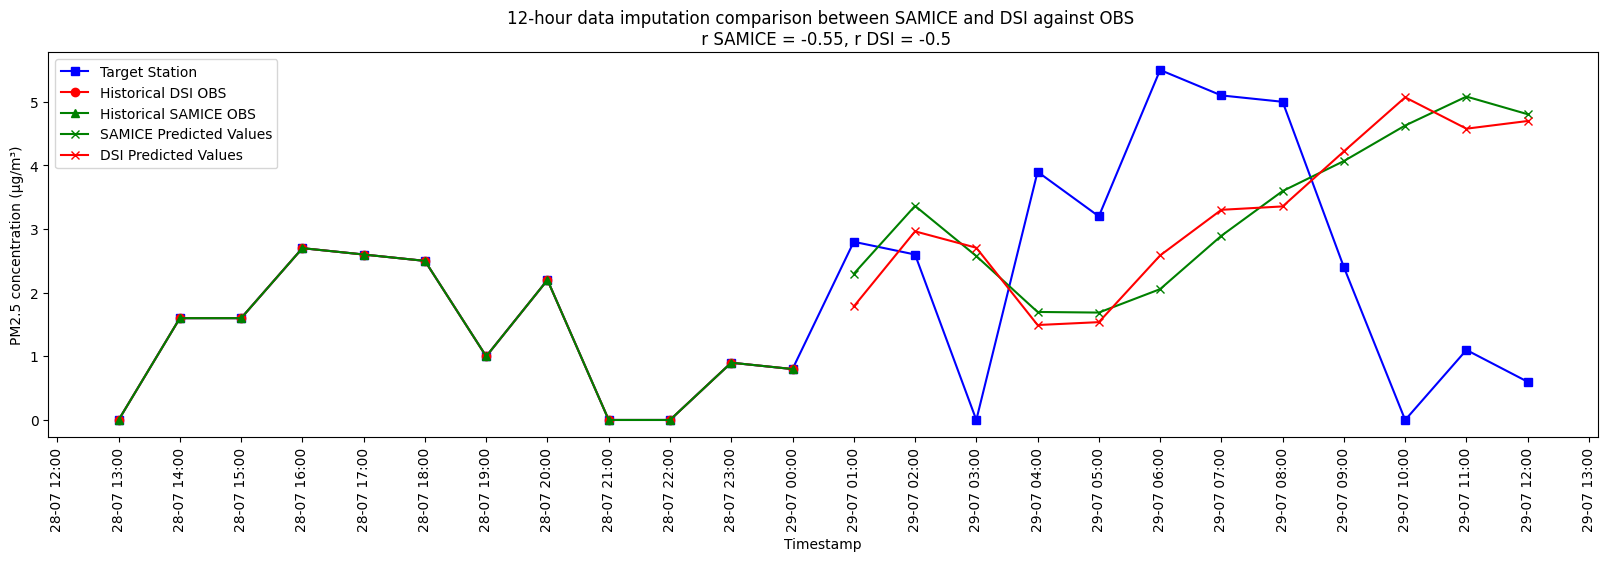

start:  2024-07-29 01:00:00
end:  2024-07-30 00:00:00


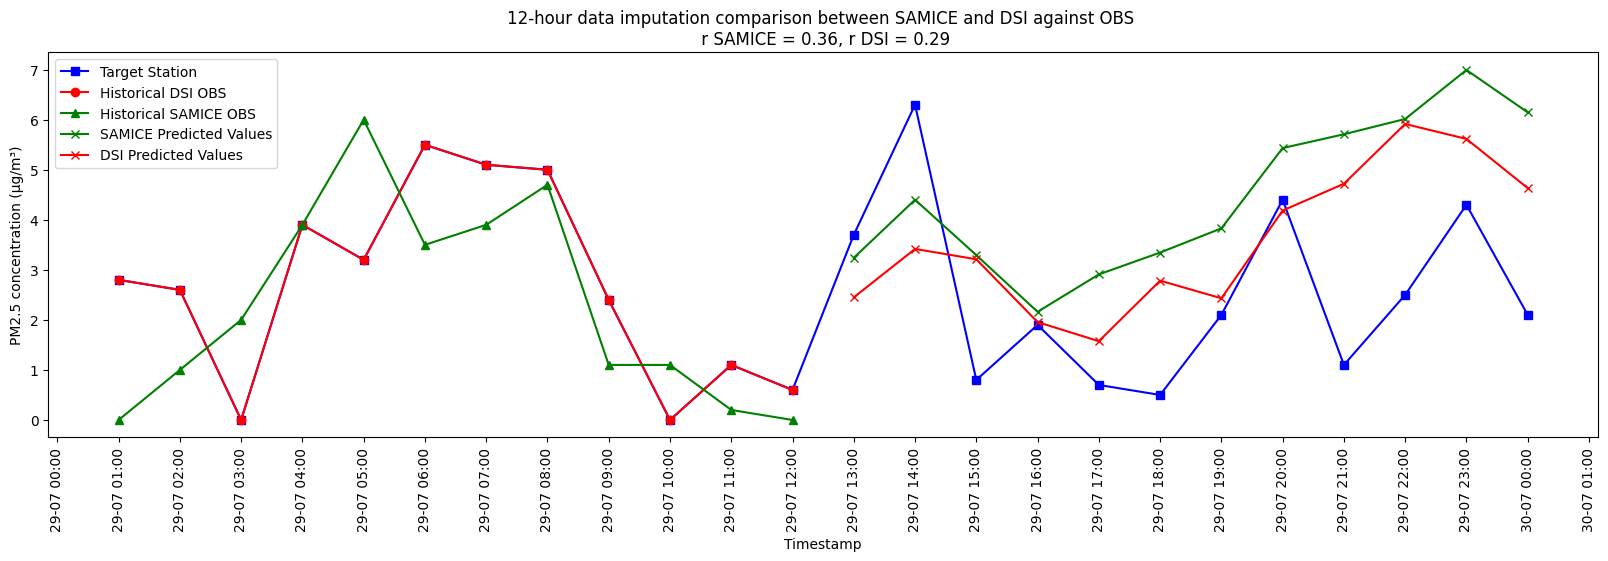

start:  2024-07-29 13:00:00
end:  2024-07-30 12:00:00


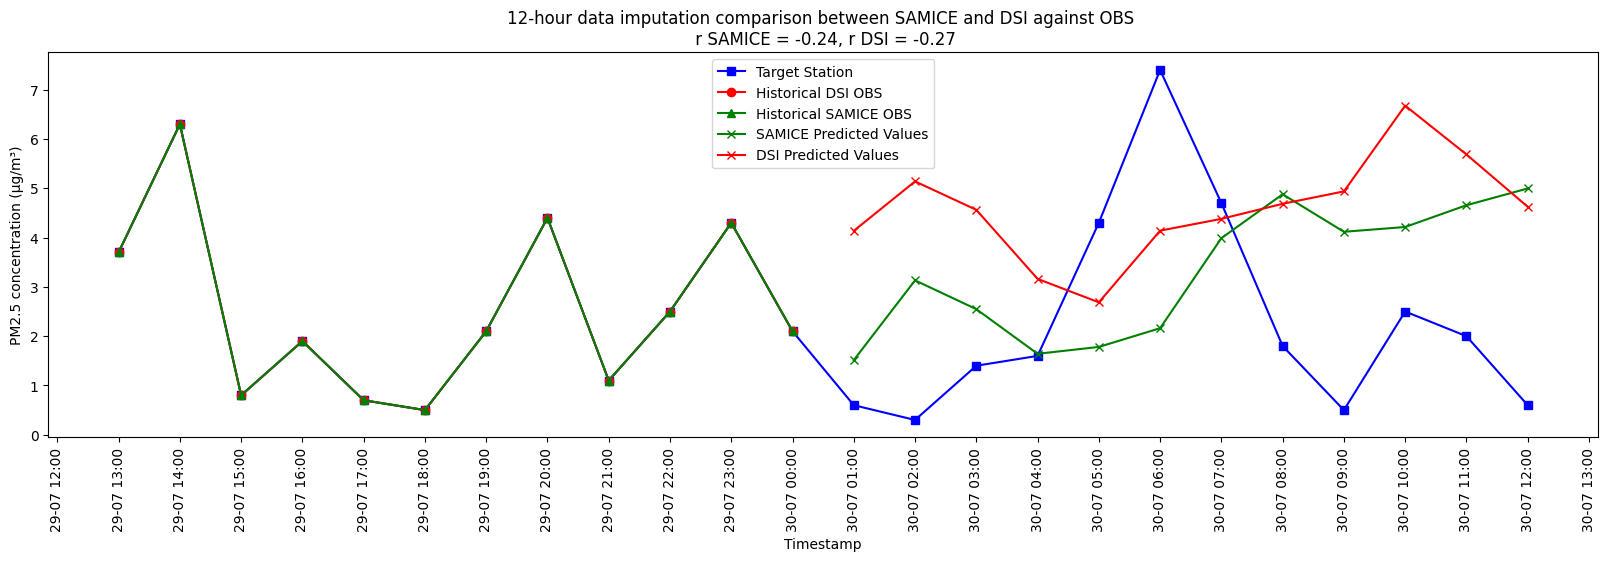

start:  2024-07-30 01:00:00
end:  2024-07-31 00:00:00


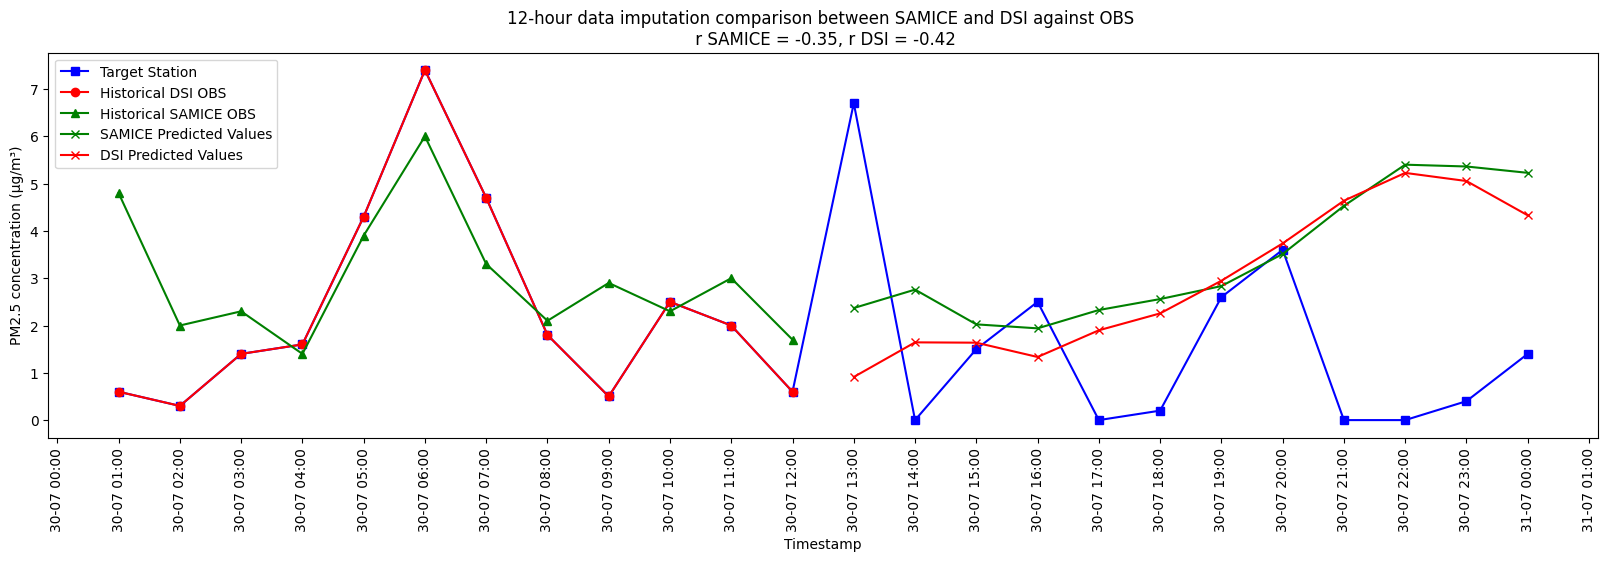

start:  2024-07-30 13:00:00
end:  2024-07-31 12:00:00


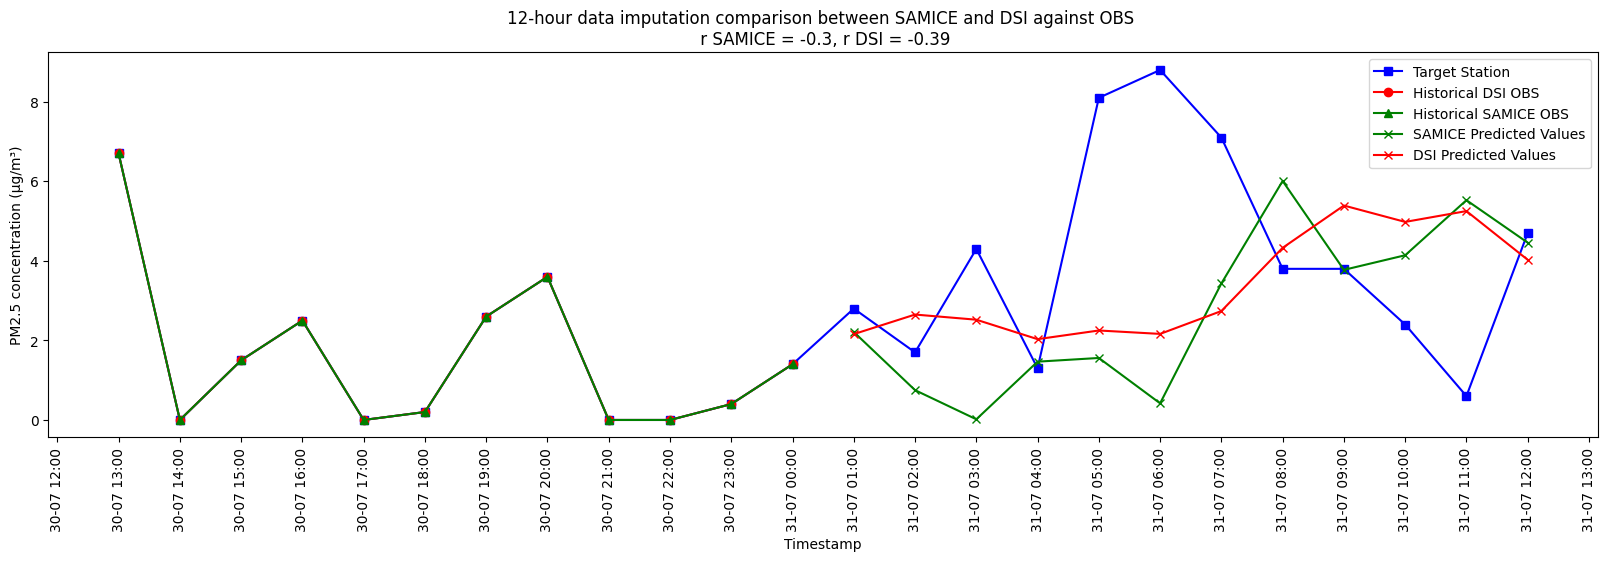

start:  2024-07-31 01:00:00
end:  2024-08-01 00:00:00


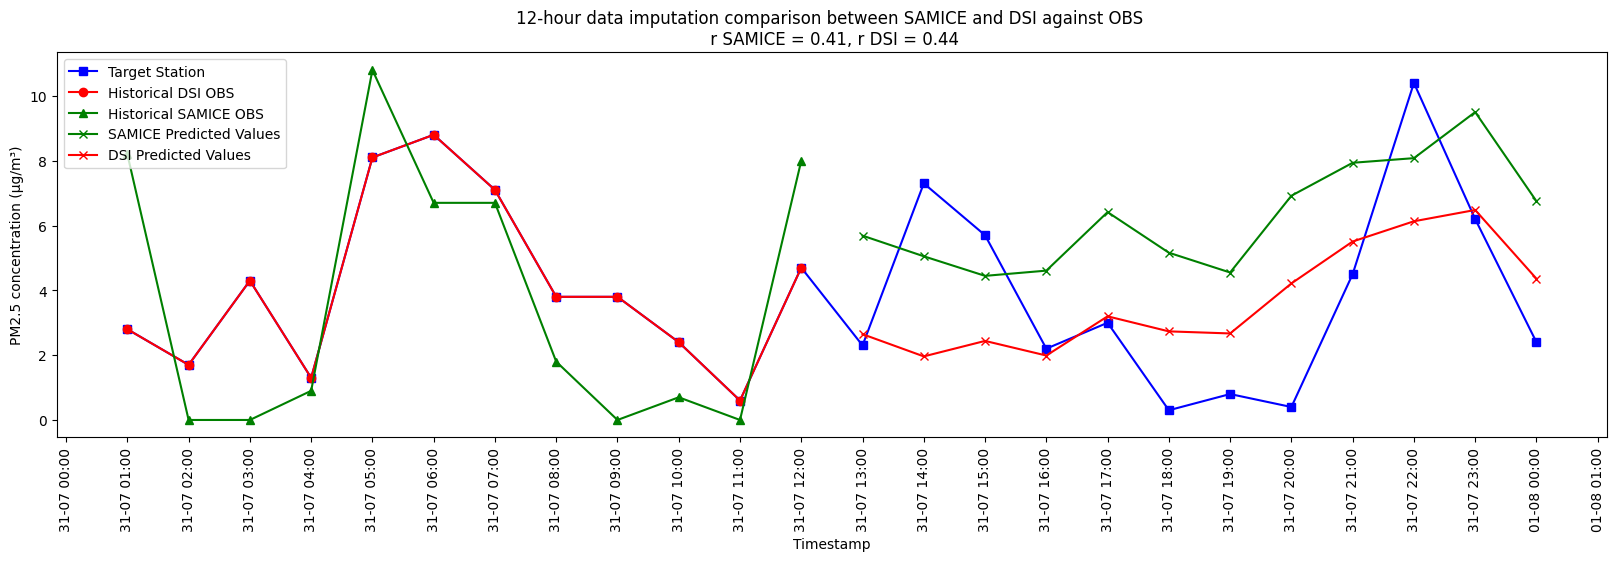

start:  2024-07-31 13:00:00
end:  2024-08-01 12:00:00


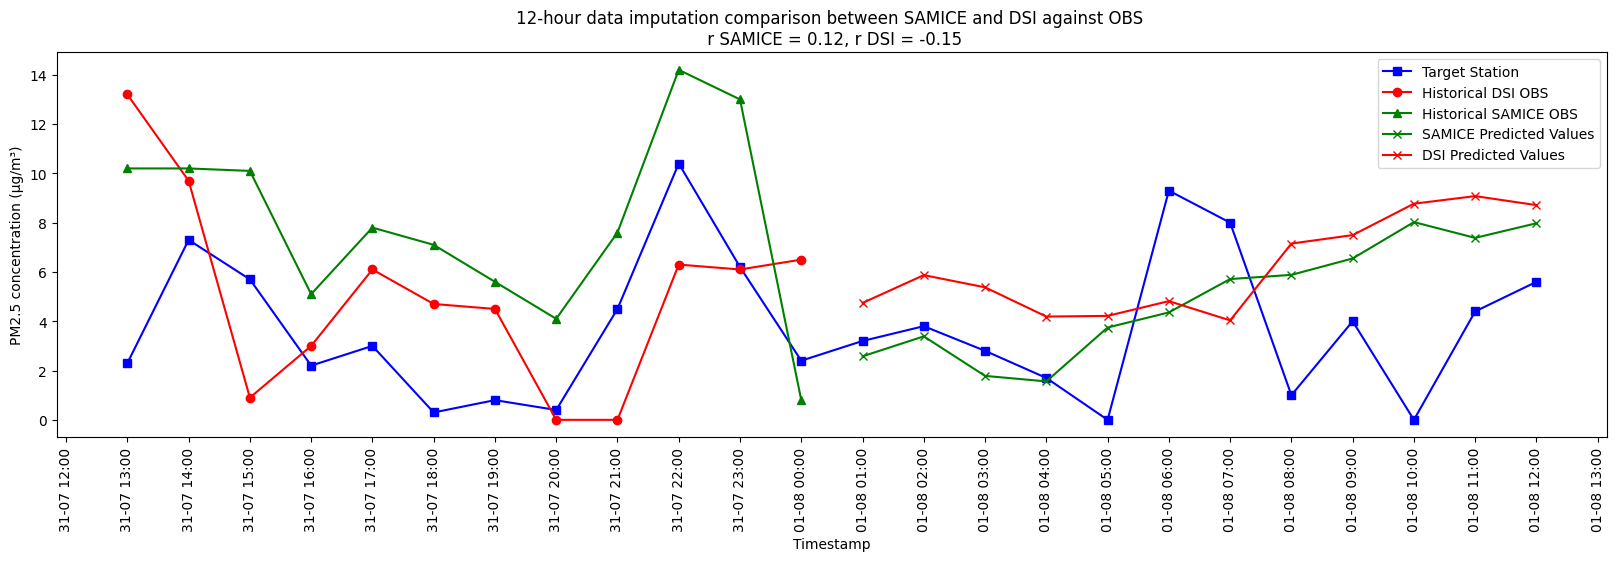

start:  2024-08-01 01:00:00
end:  2024-08-02 00:00:00


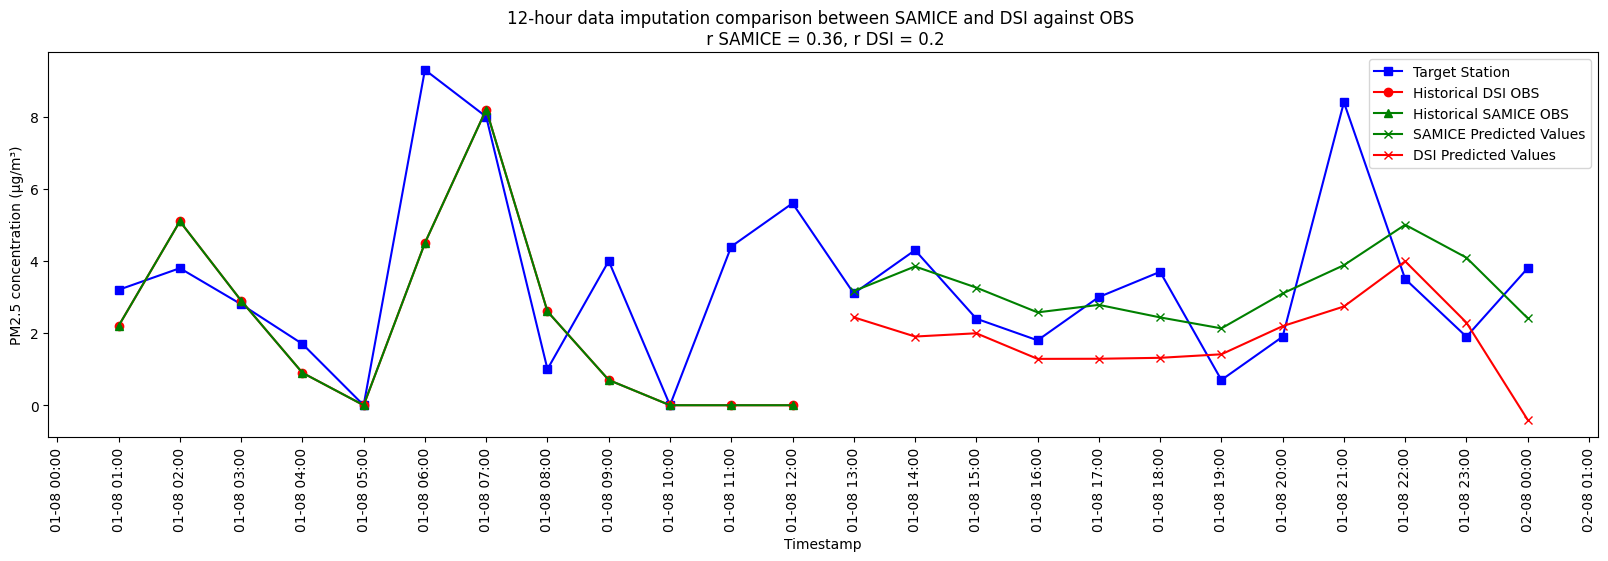

start:  2024-08-01 13:00:00
end:  2024-08-02 12:00:00


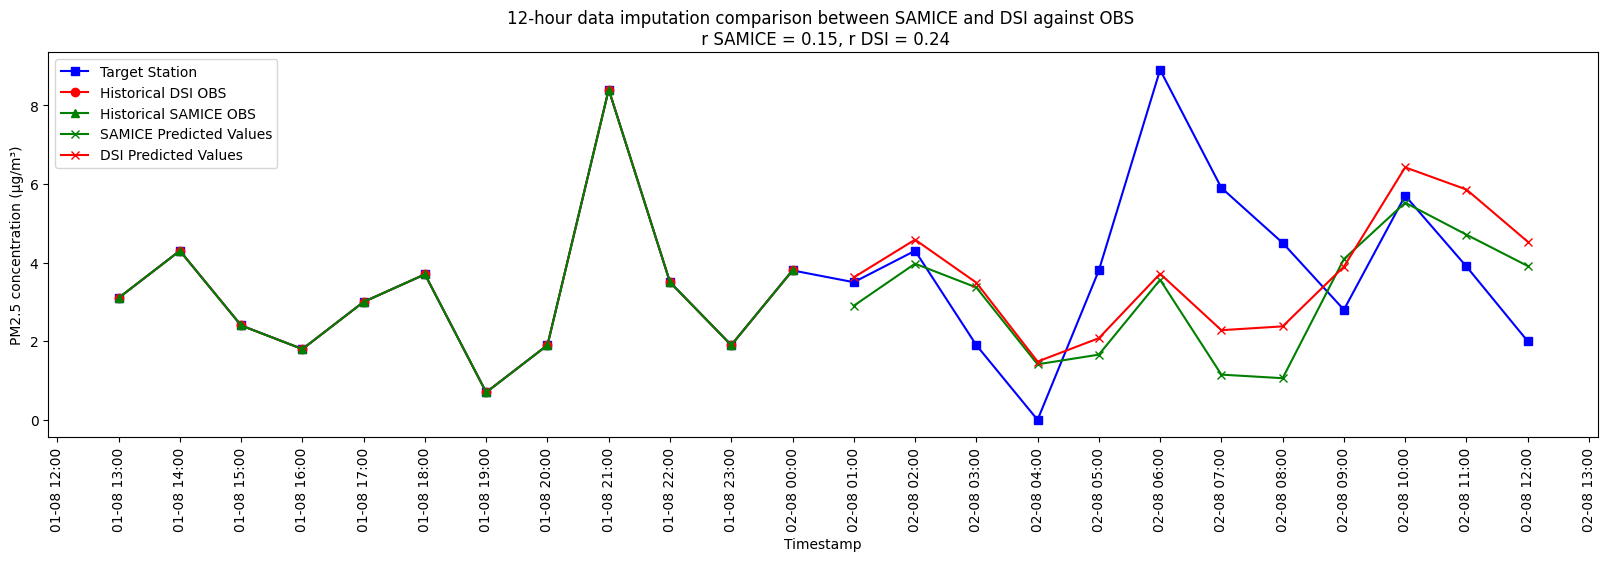

start:  2024-08-02 01:00:00
end:  2024-08-02 20:00:00


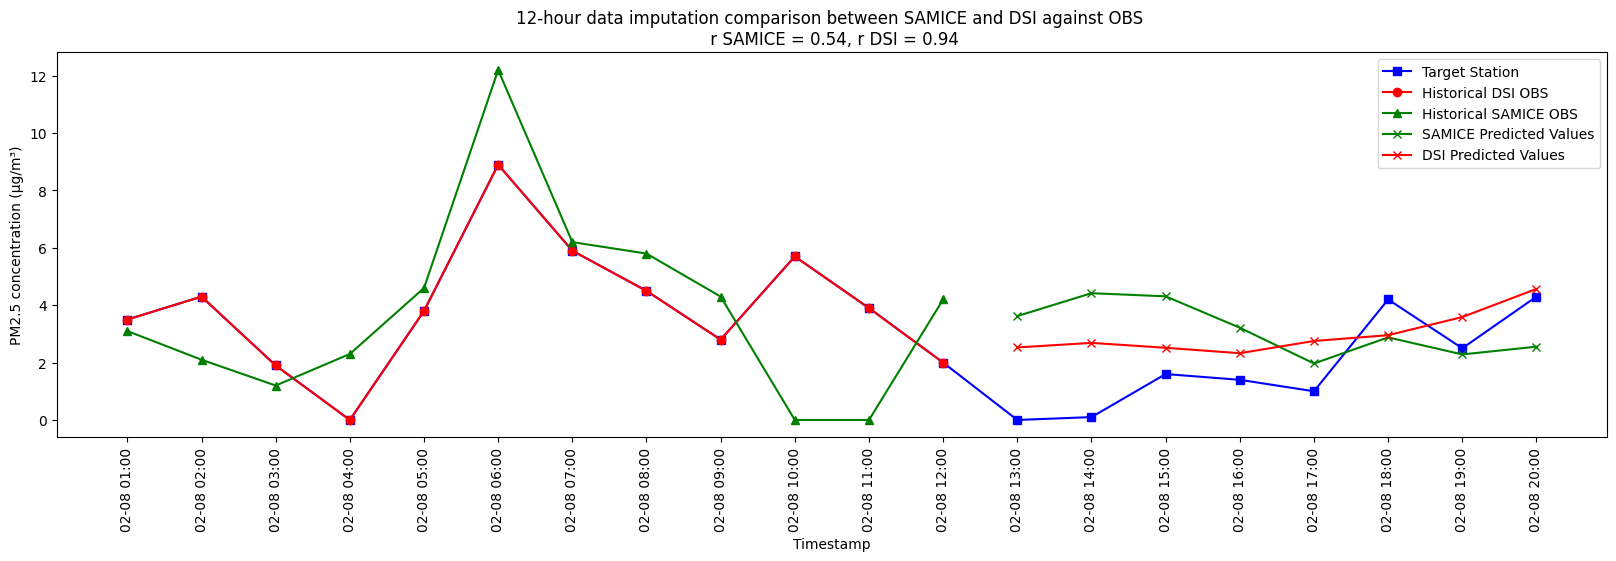

start:  2024-08-02 13:00:00
end:  2024-08-03 12:00:00


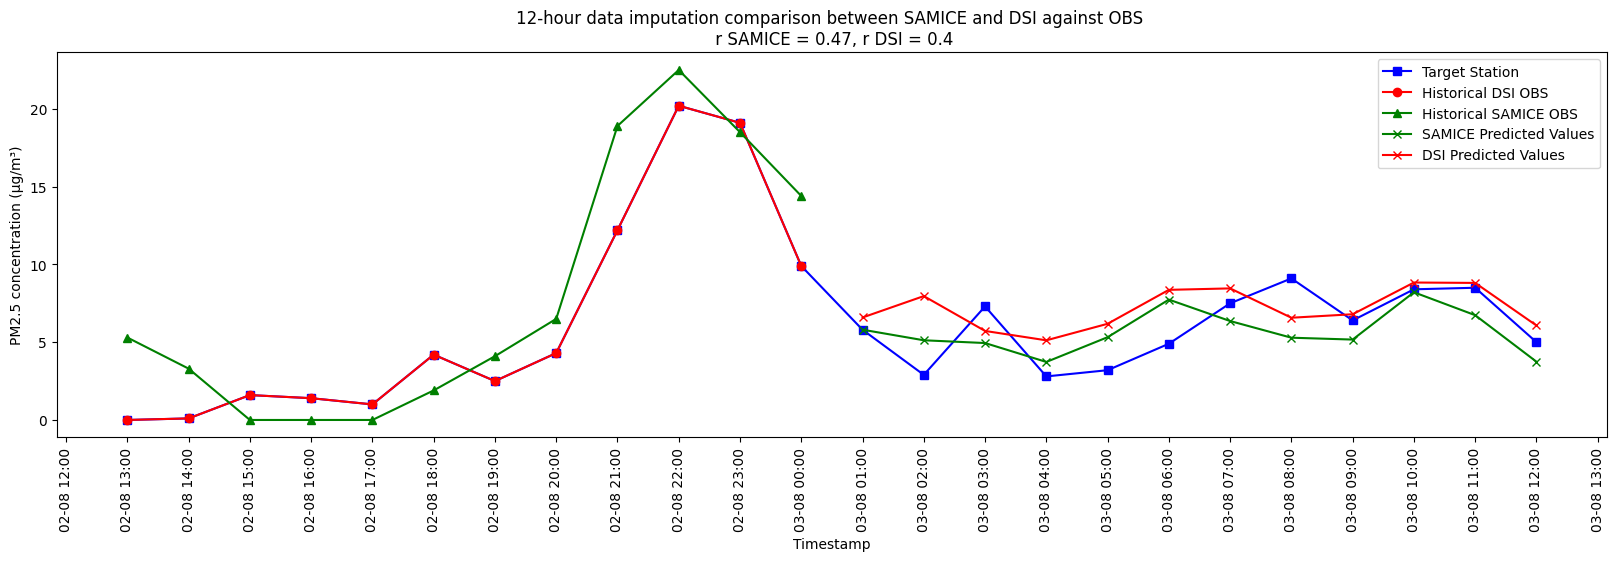

start:  2024-08-03 01:00:00
end:  2024-08-04 00:00:00


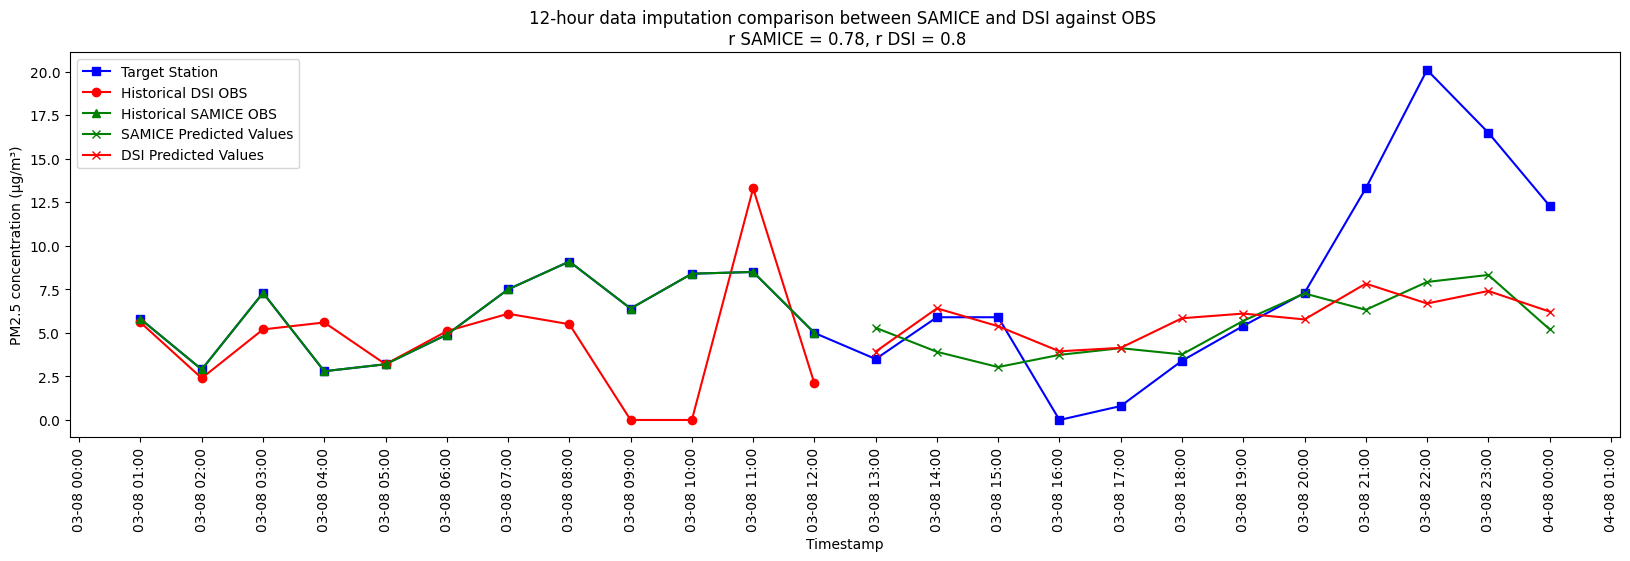

start:  2024-08-03 13:00:00
end:  2024-08-04 12:00:00


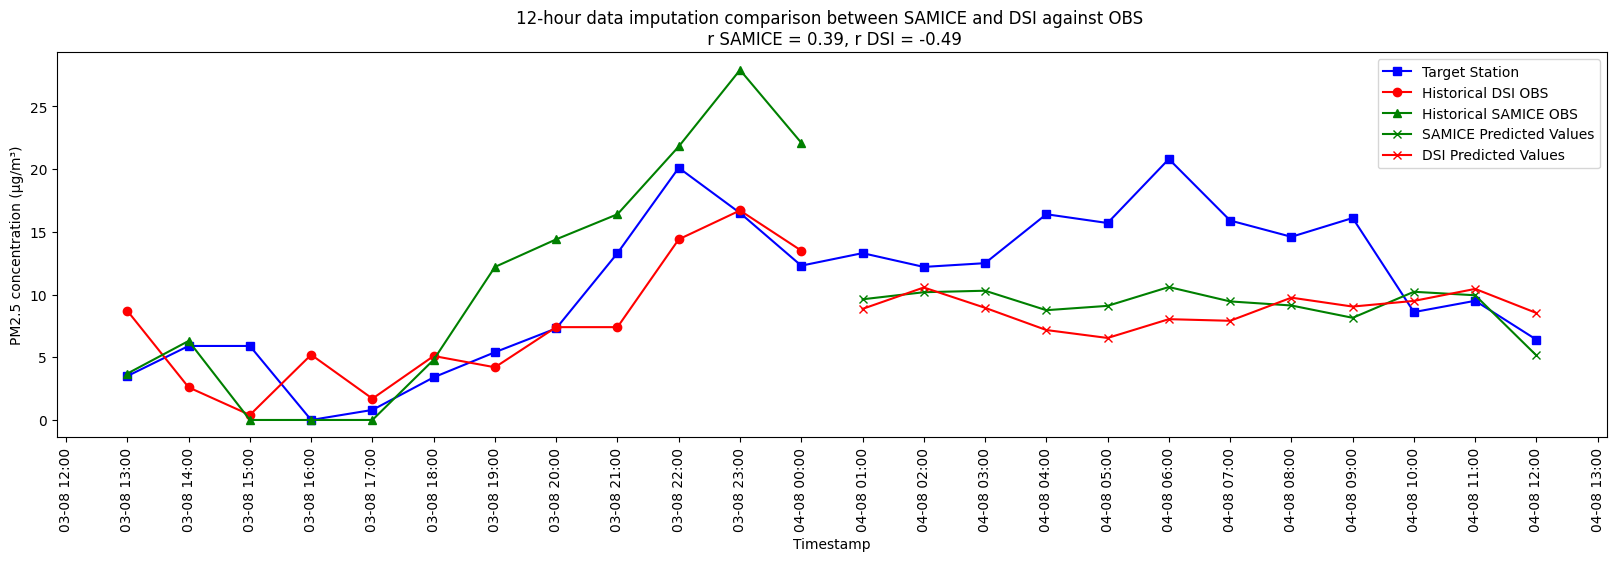

start:  2024-08-04 01:00:00
end:  2024-08-05 00:00:00


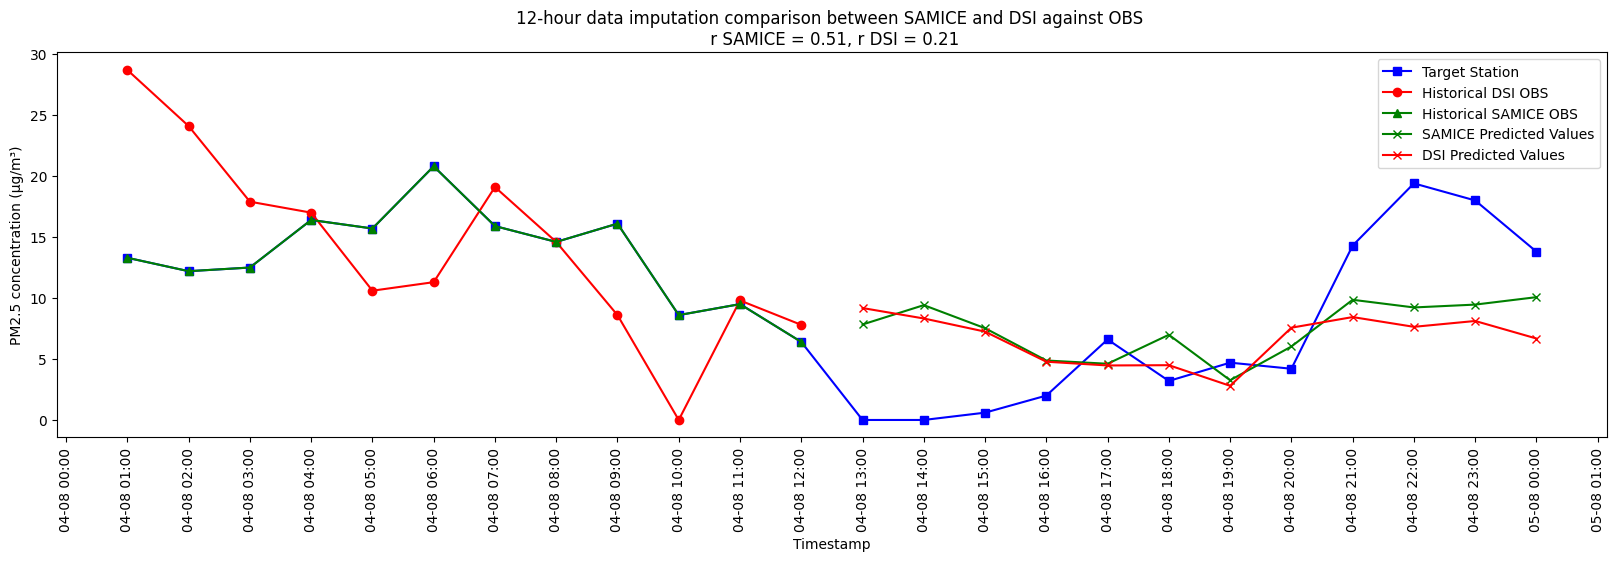

start:  2024-08-04 13:00:00
end:  2024-08-05 12:00:00


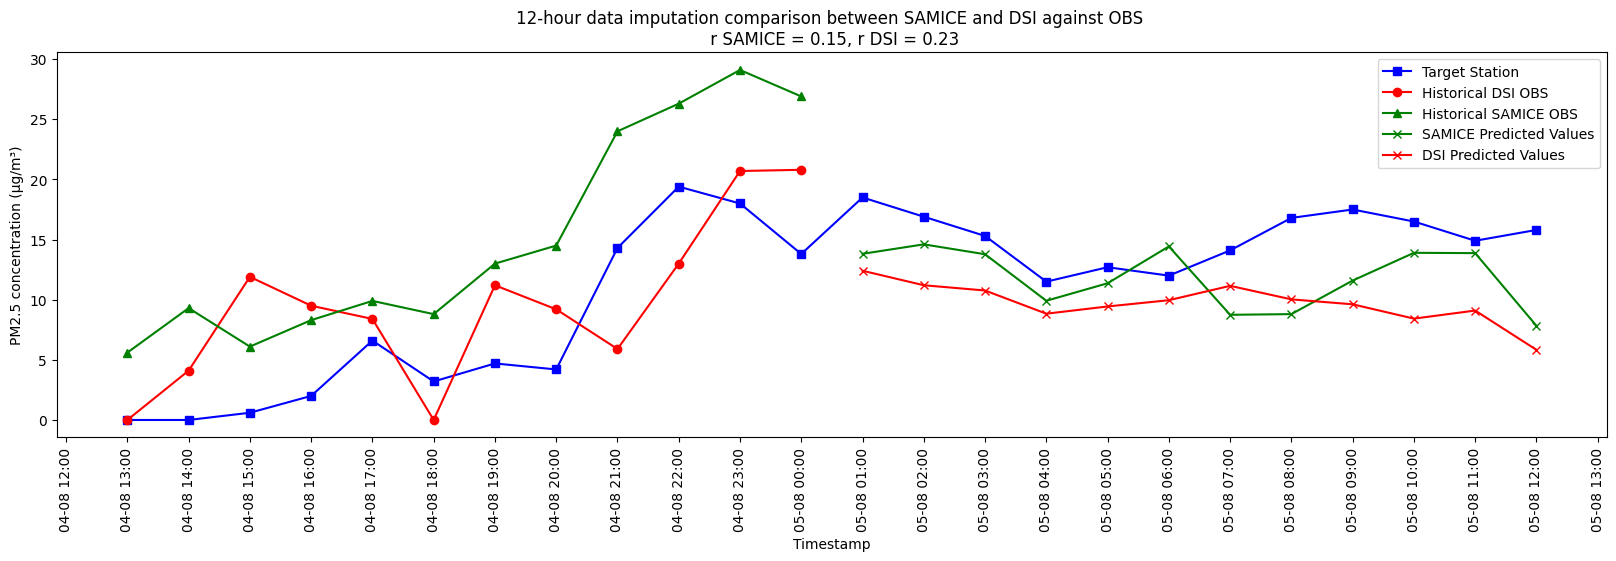

start:  2024-08-05 01:00:00
end:  2024-08-06 00:00:00


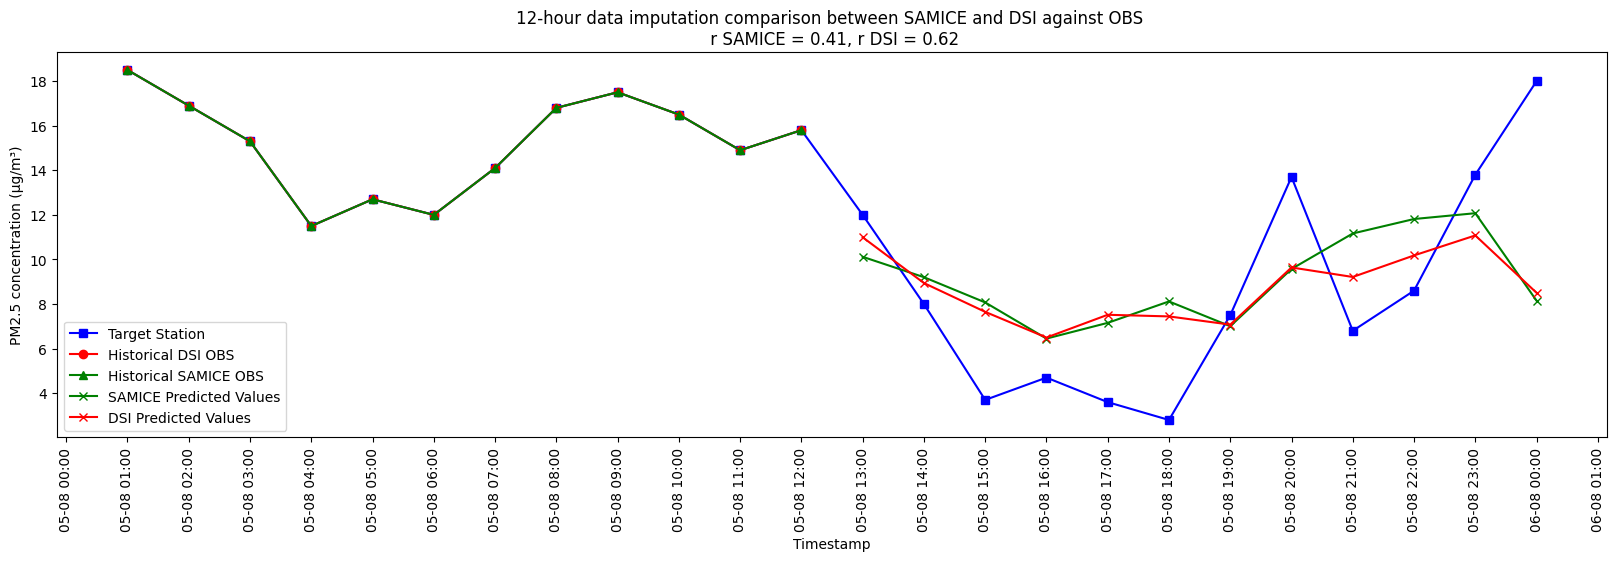

start:  2024-08-05 13:00:00
end:  2024-08-06 12:00:00


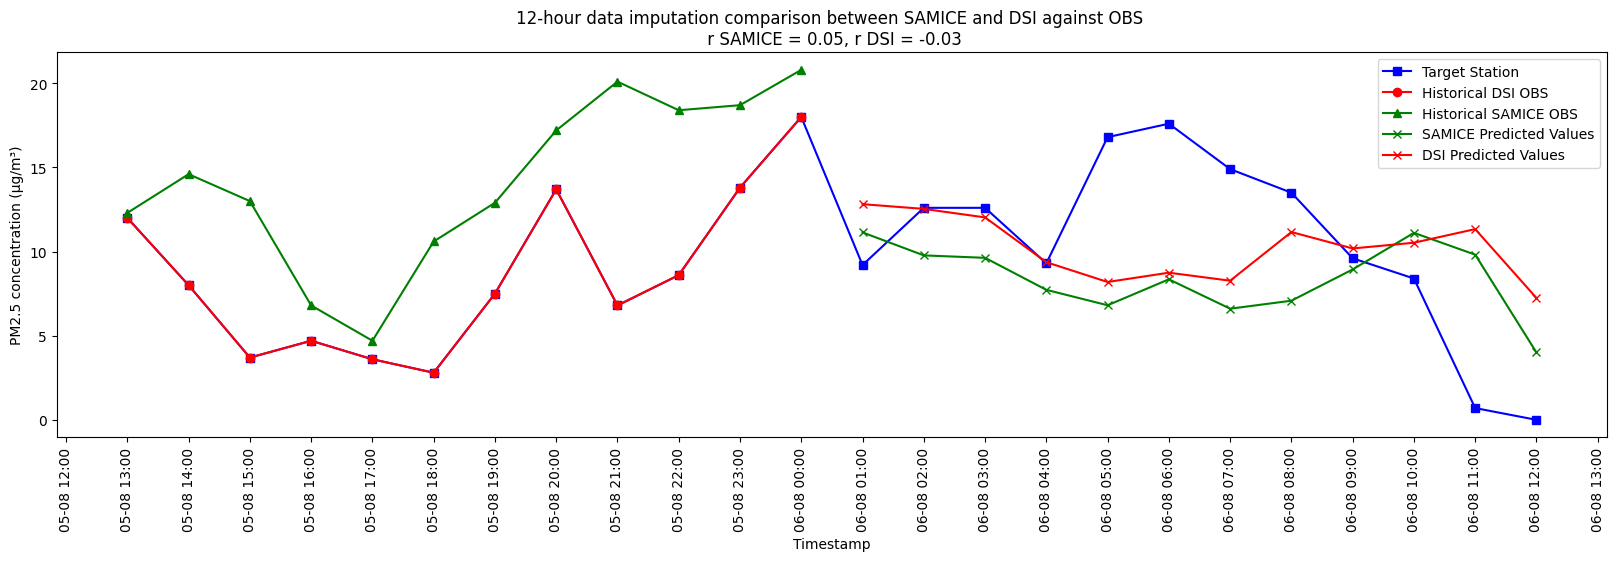

start:  2024-08-06 01:00:00
end:  2024-08-07 00:00:00


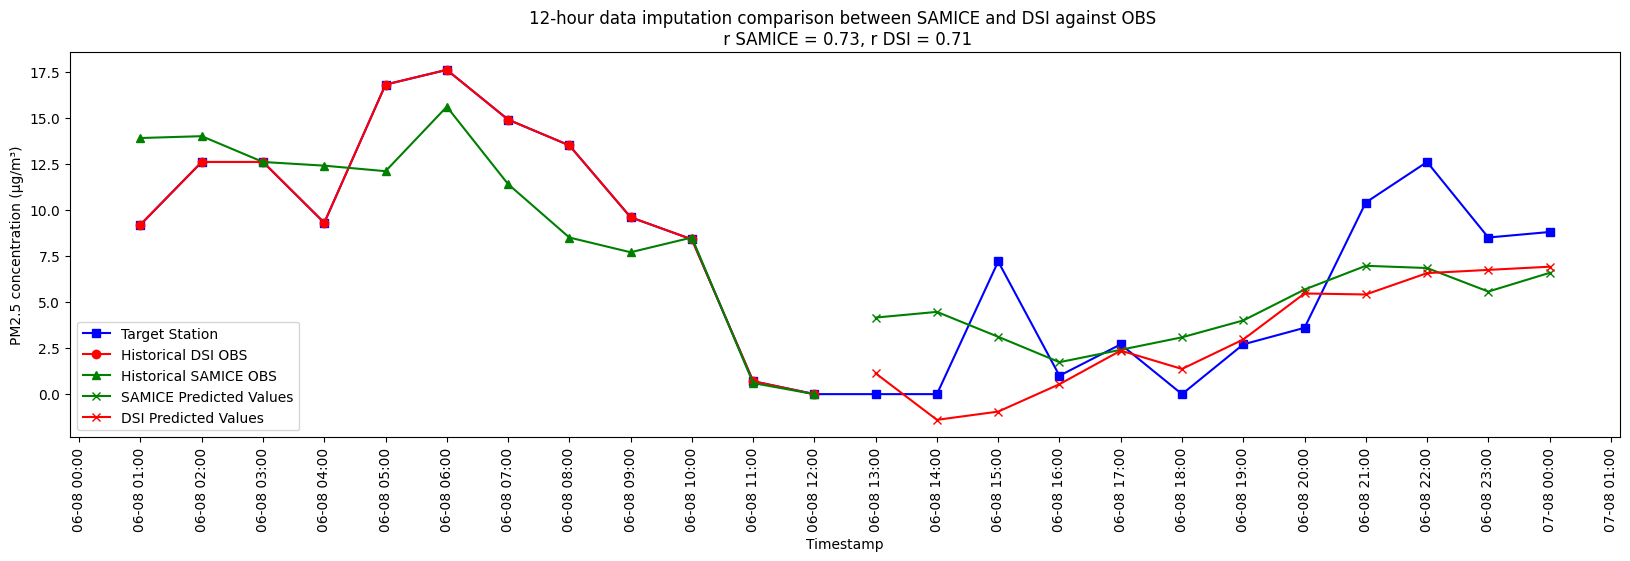

start:  2024-08-06 13:00:00
end:  2024-08-07 12:00:00


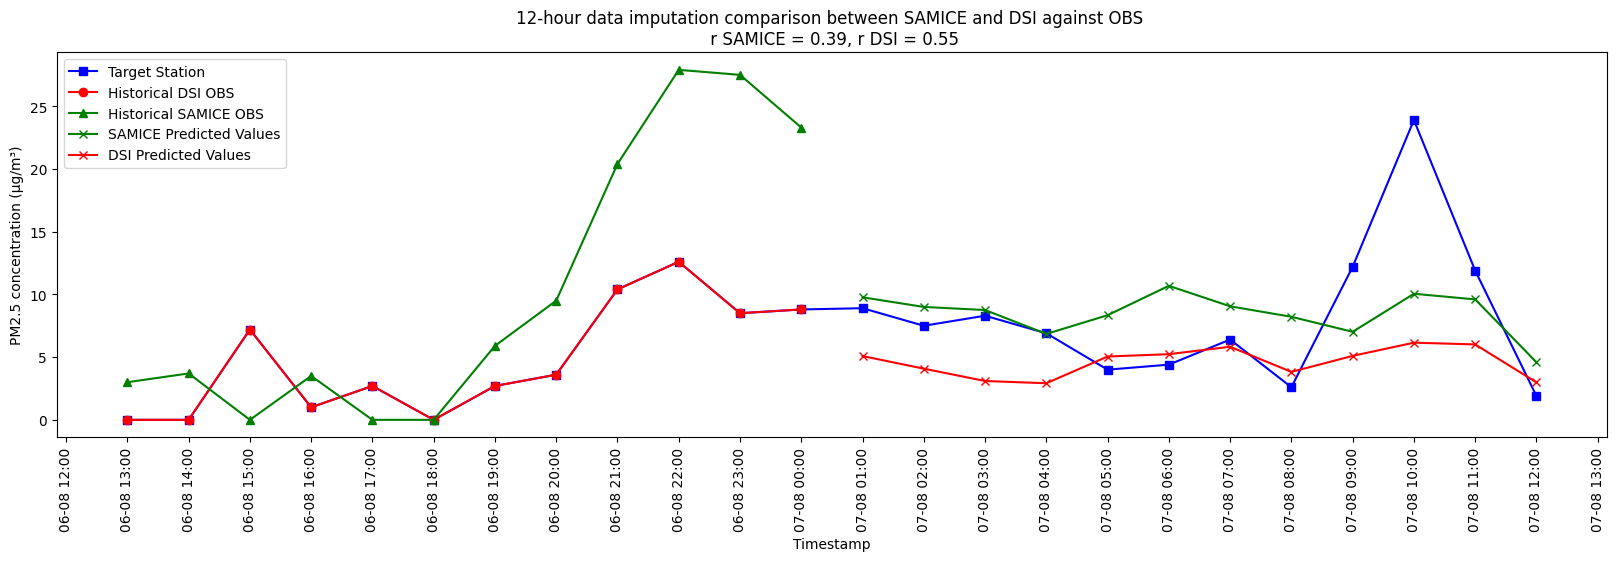

start:  2024-08-07 01:00:00
end:  2024-08-08 00:00:00


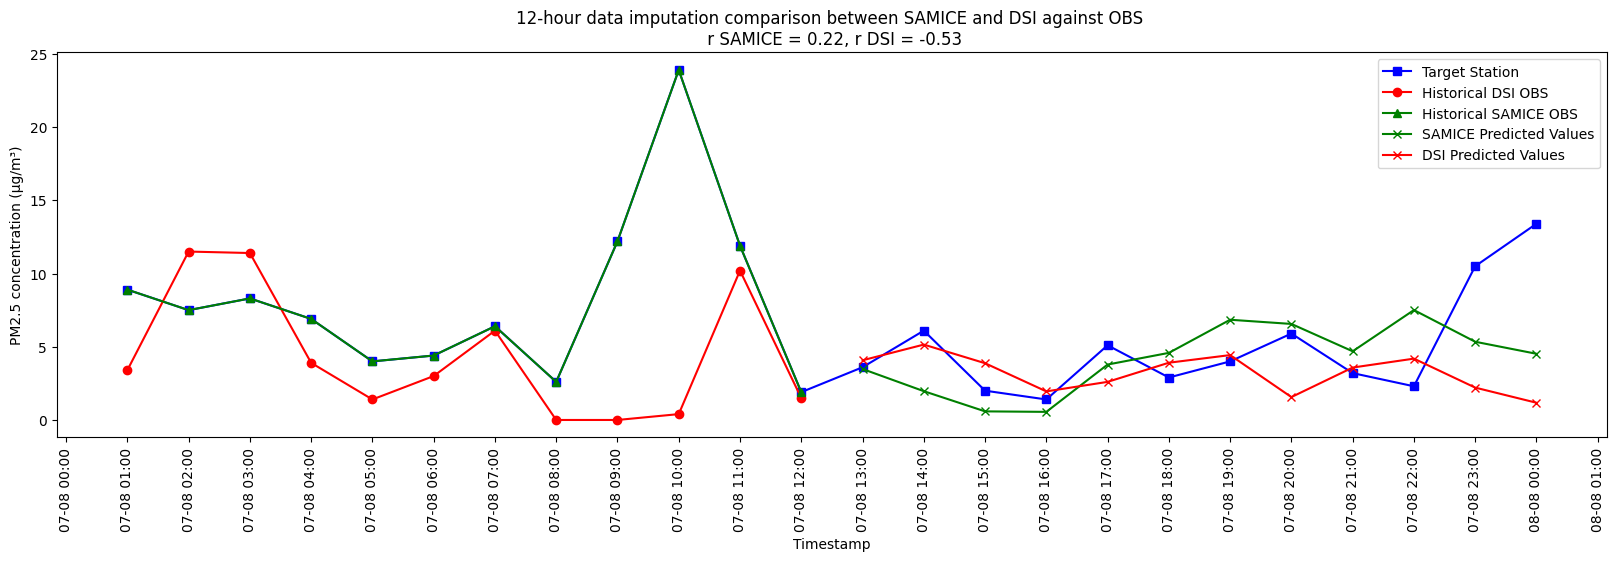

start:  2024-08-07 13:00:00
end:  2024-08-08 12:00:00


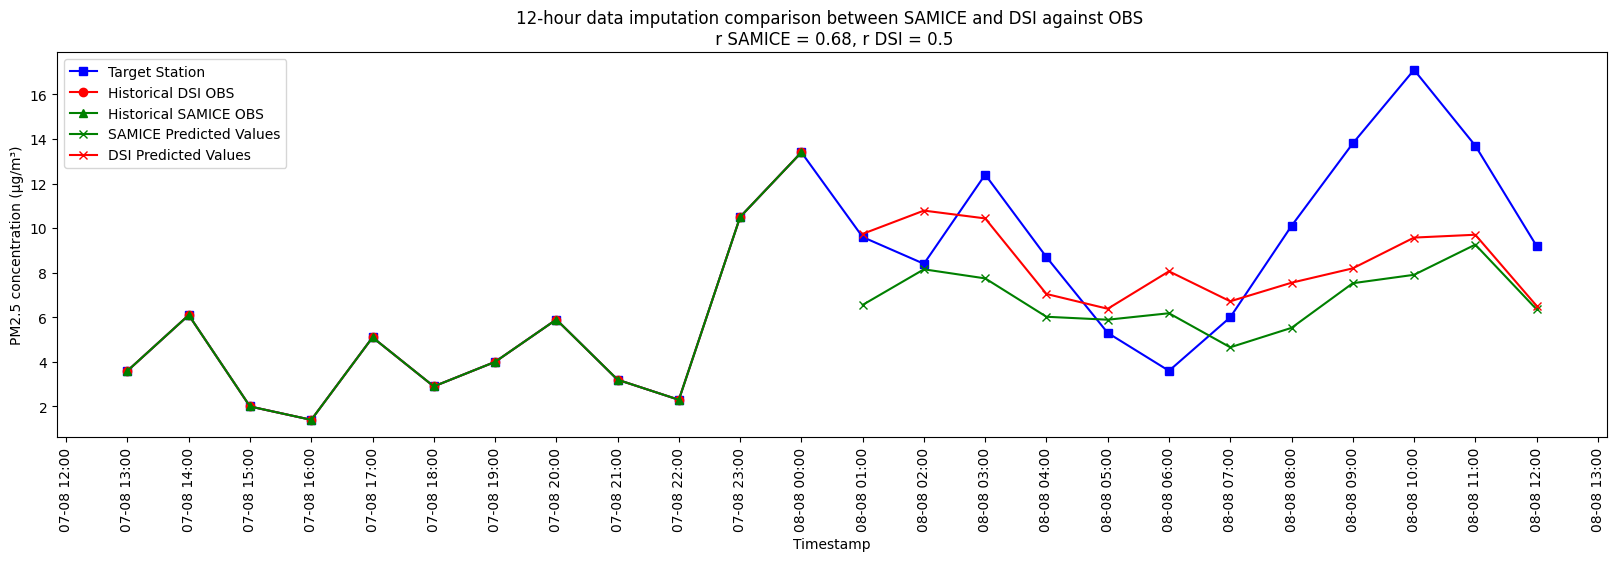

start:  2024-08-08 01:00:00
end:  2024-08-09 00:00:00


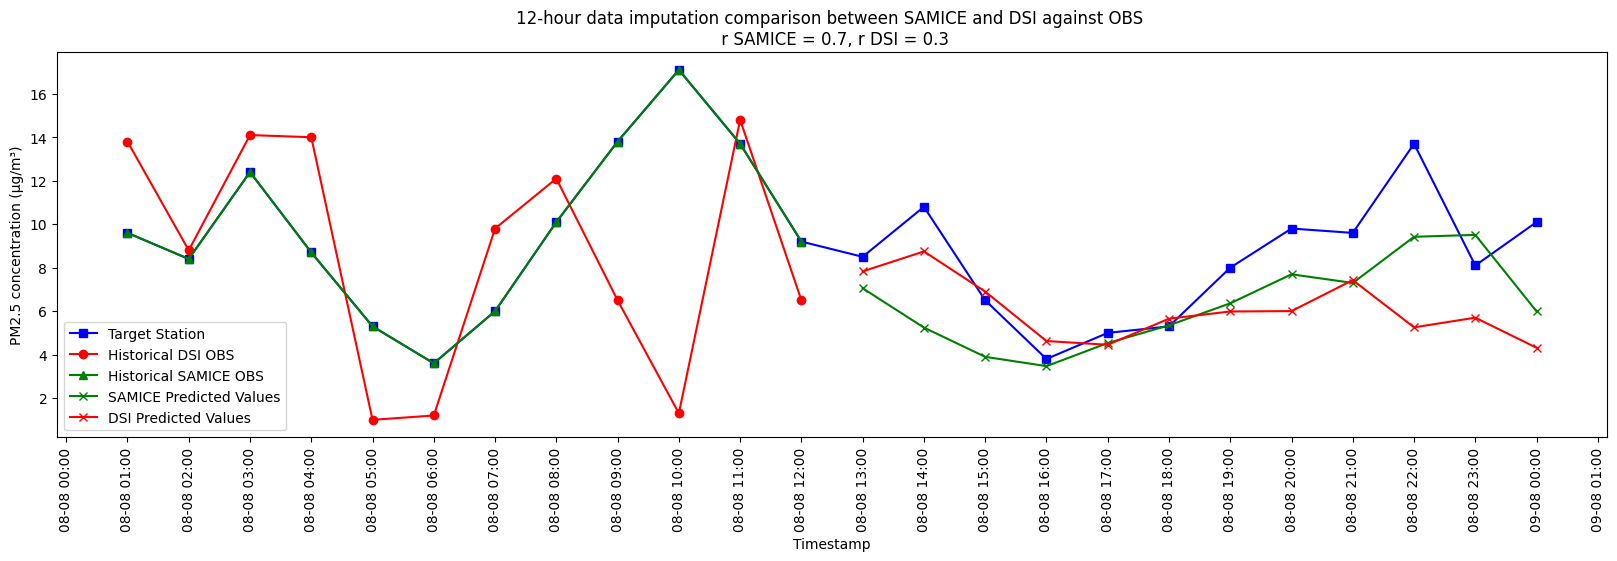

start:  2024-08-08 13:00:00
end:  2024-08-09 12:00:00


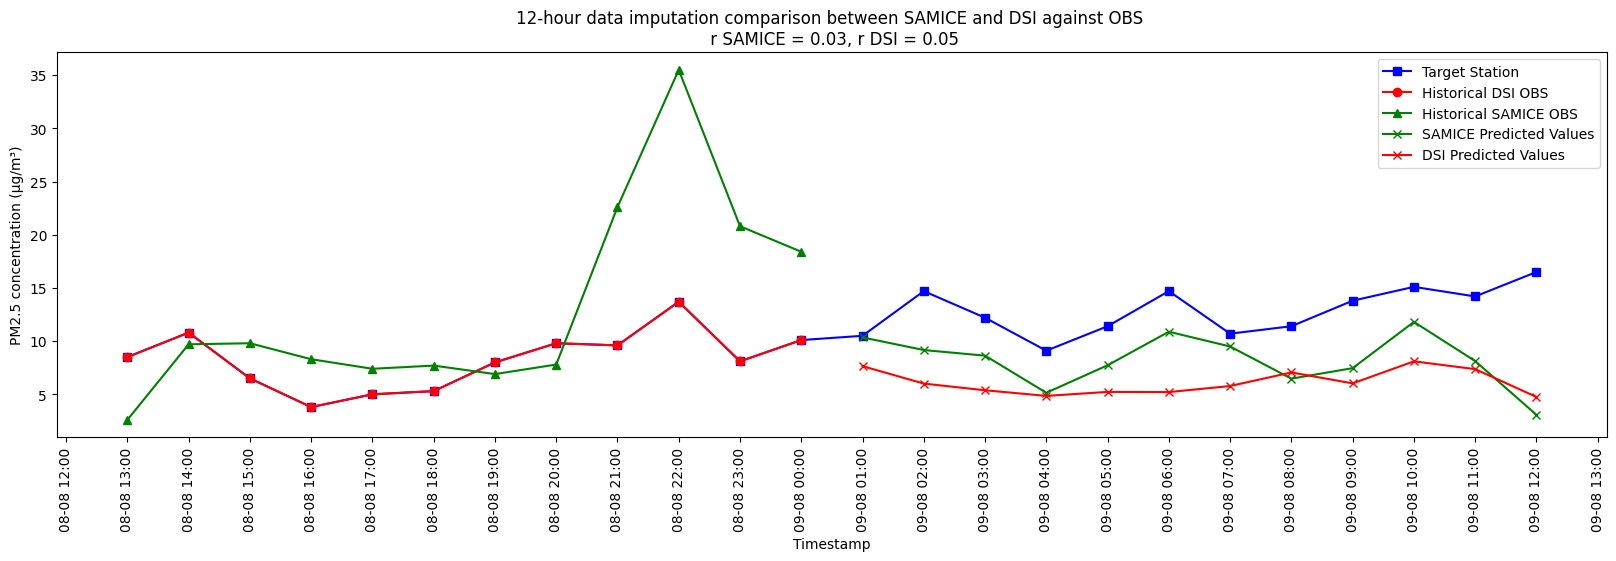

start:  2024-08-09 01:00:00
end:  2024-08-10 00:00:00


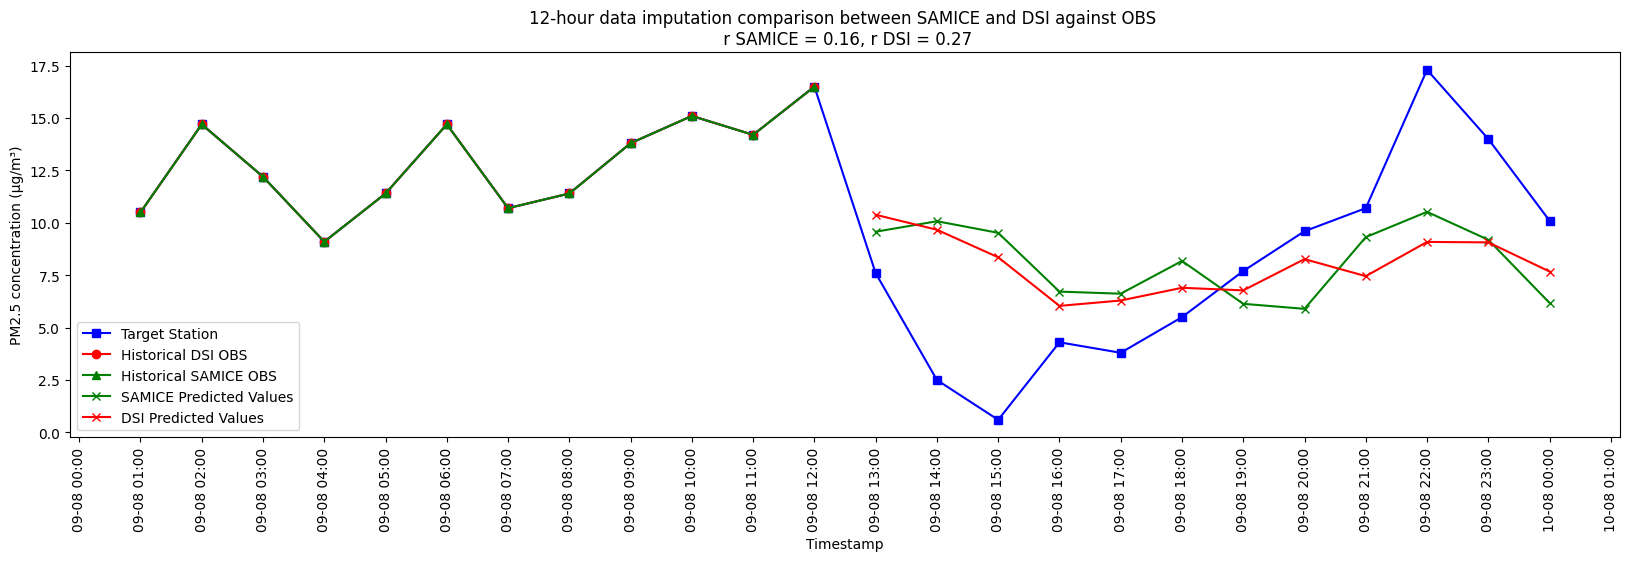

start:  2024-08-09 13:00:00
end:  2024-08-10 12:00:00


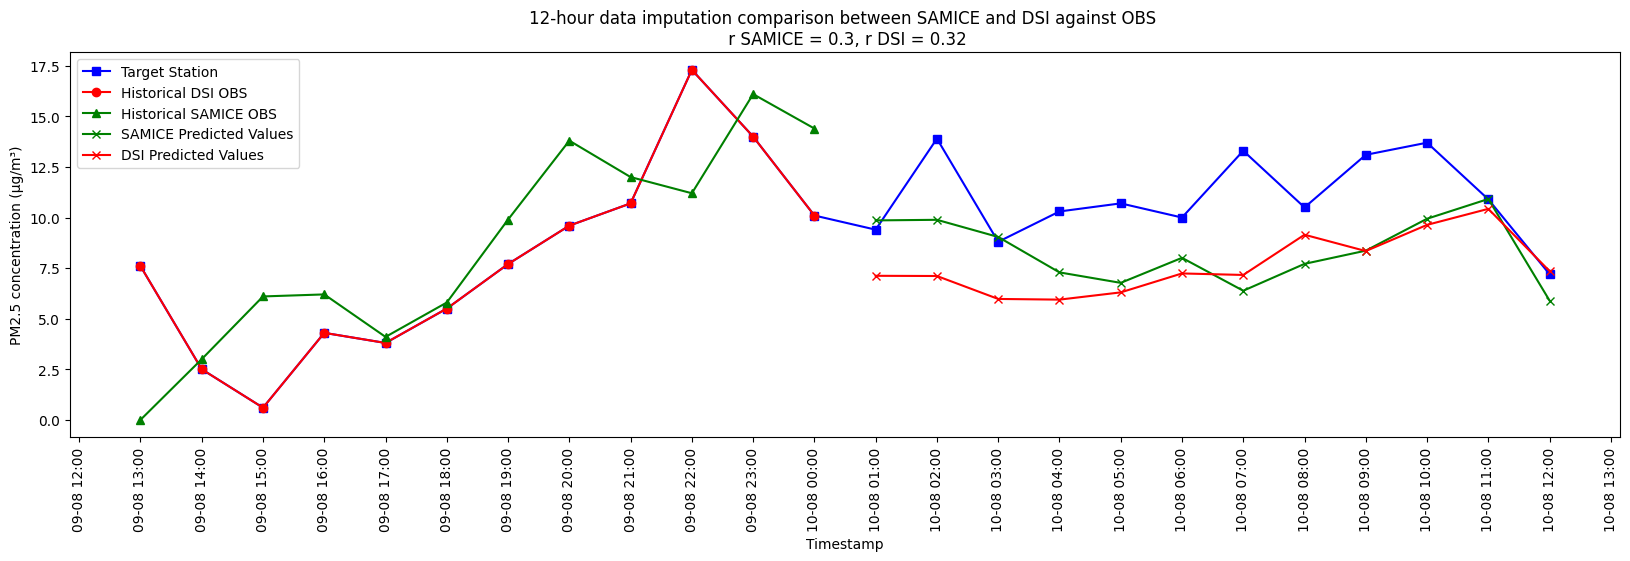

start:  2024-08-10 01:00:00
end:  2024-08-11 00:00:00


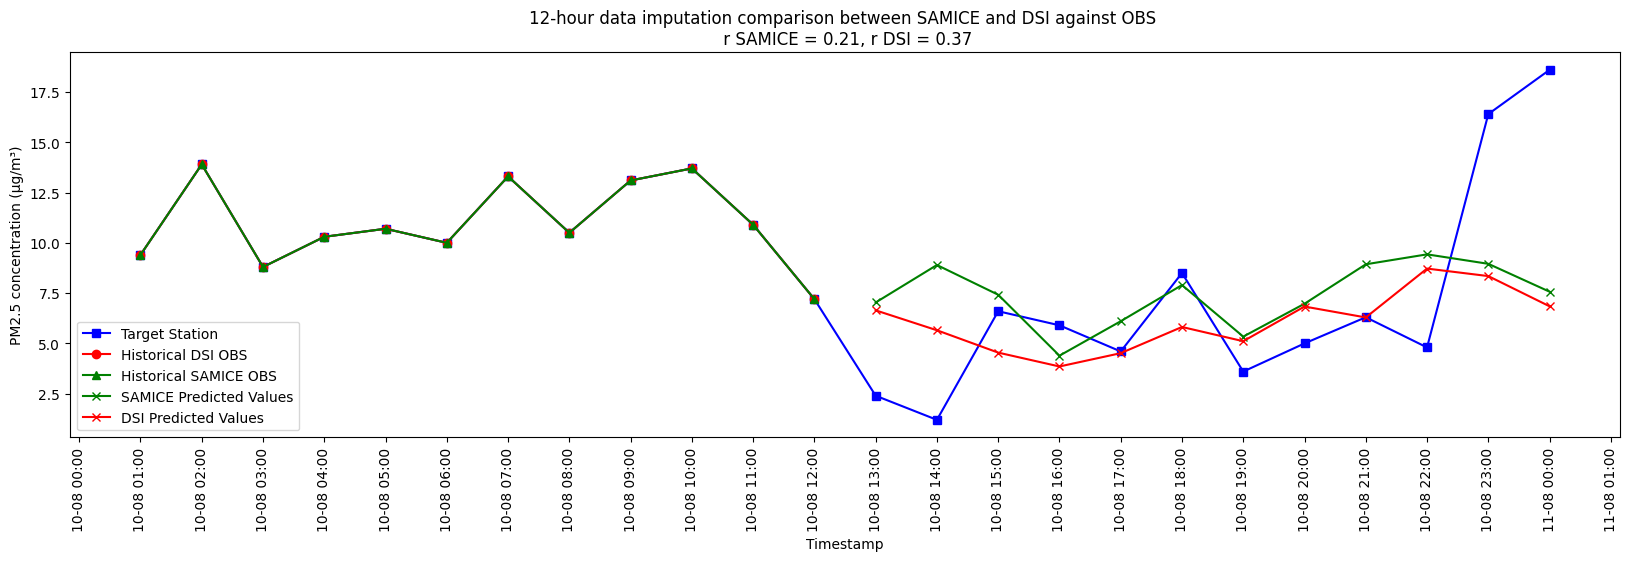

start:  2024-08-10 13:00:00
end:  2024-08-11 12:00:00


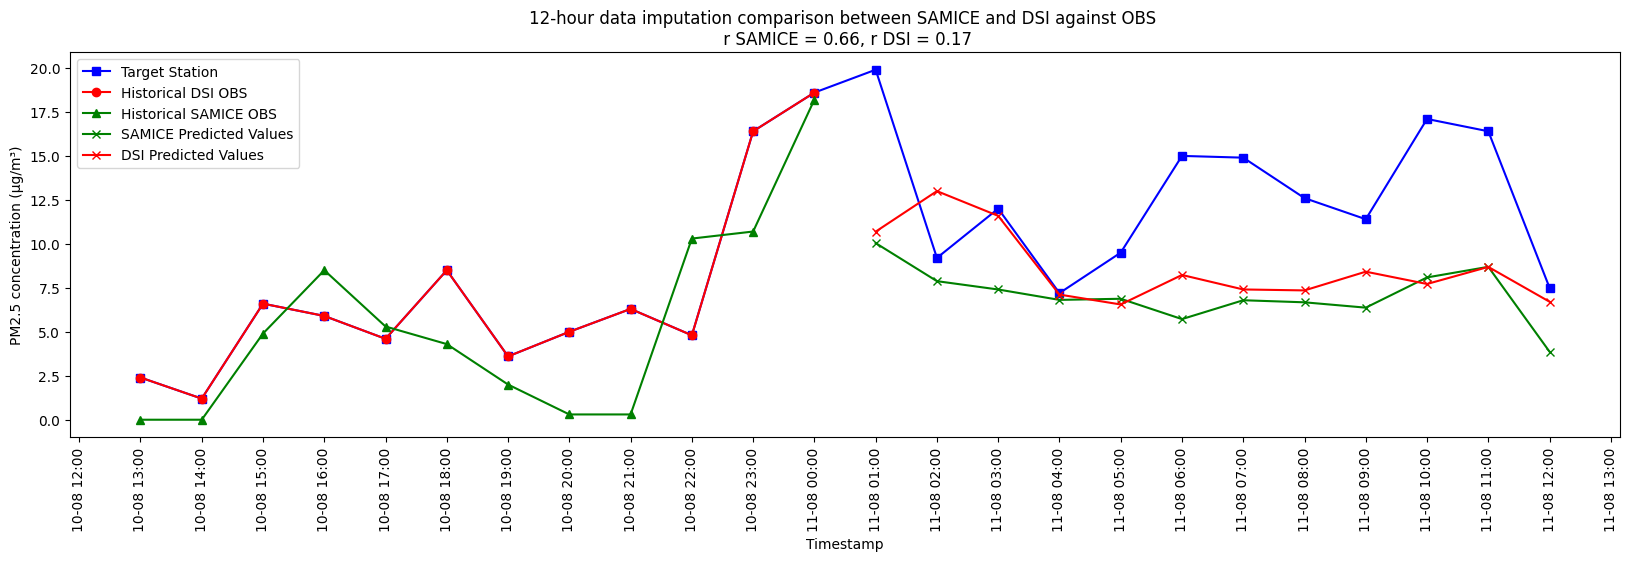

start:  2024-08-11 01:00:00
end:  2024-08-12 00:00:00


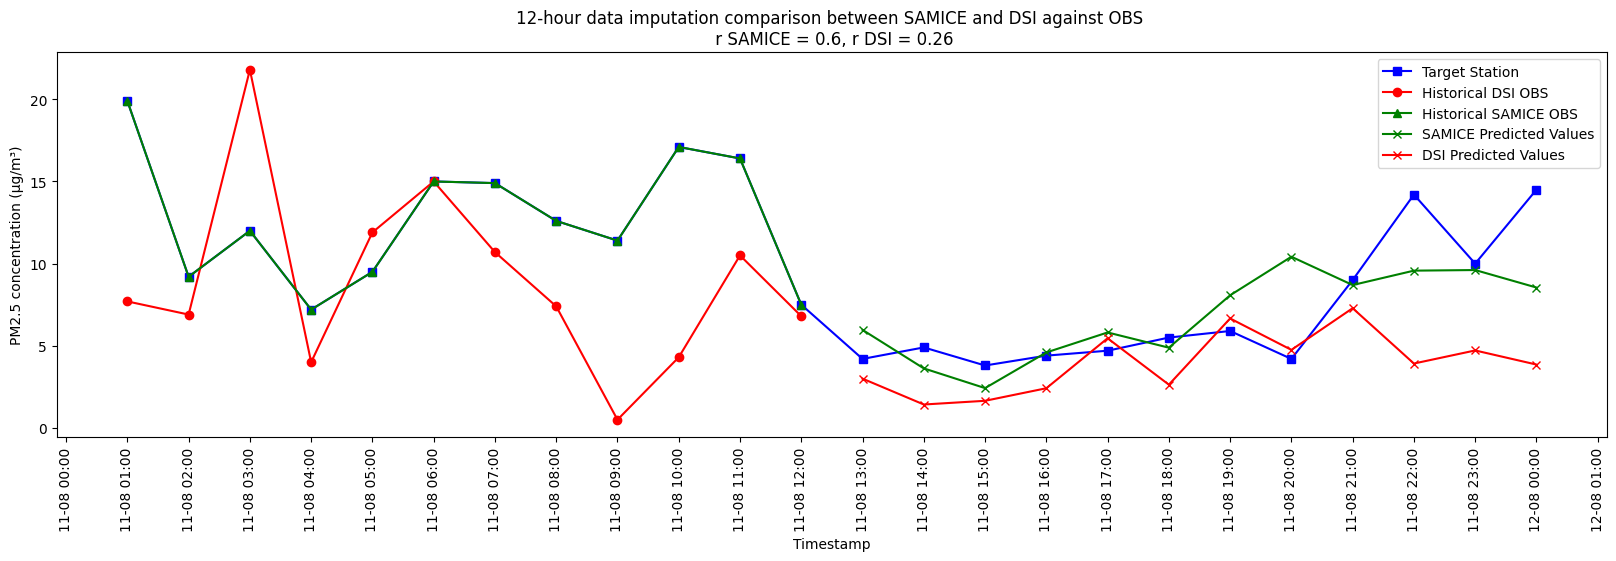

start:  2024-08-11 13:00:00
end:  2024-08-12 12:00:00


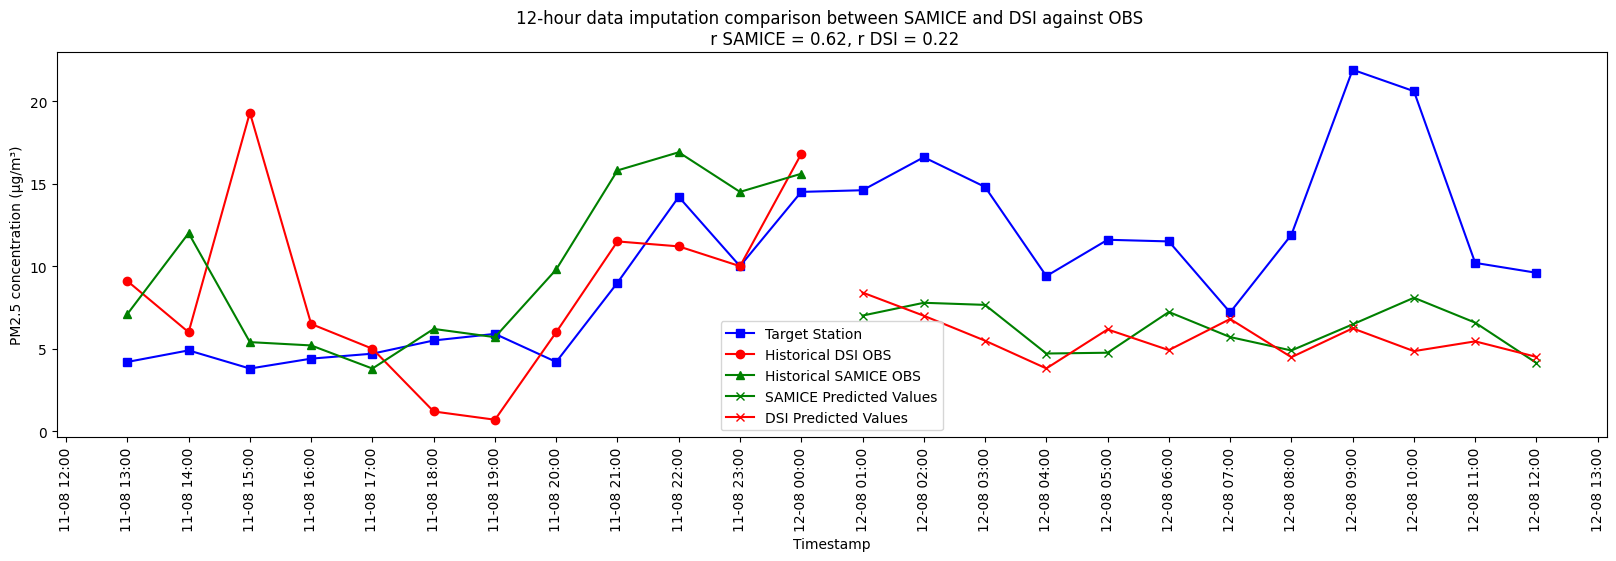

In [61]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Plot each set of X_test with its corresponding y_pred
for i in range(X_test_dsi.shape[0]):
    fig, ax = plt.subplots(figsize=(20, 5))

    # Determine the start time for slicing target_station
    start_time = X_test_indeces_dsi[i][0]
    start_time = pd.Timestamp(start_time)  # Convert start_time to Timestamp object
    if i == 9:
        end_time = start_time + pd.Timedelta(hours=19)
    else:
        end_time = start_time + pd.Timedelta(hours=23)
    print("start: ", start_time)
    print("end: ", end_time)
    # Slice target_station for the next 24 hours
    target_station_slice = target_station.loc[start_time:end_time]

    # Plot the sliced target_station data
    ax.plot(
        target_station_slice.index,
        target_station_slice.iloc[:, 0],  # Assuming the first (and only) column
        label="Target Station",
        marker="s",
        color="blue",
    )

    # Plot historical values (X_test)
    X_test_indeces_dsi[i] = pd.to_datetime(
        X_test_indeces_dsi[i], format="%d/%m/%Y %H:%M"
    )

    ax.plot(
        X_test_indeces_dsi[i],
        X_test_dsi[i],
        label="Historical DSI OBS",
        marker="o",
        color="red",
    )

    X_test_indeces_samice[i] = pd.to_datetime(
        X_test_indeces_dsi[i], format="%d/%m/%Y %H:%M"
    )
    if i == 0:
        print("AA:", X_test_indeces_samice)
    ax.plot(
        X_test_indeces_samice[i],
        X_test_samice[i],
        label="Historical SAMICE OBS",
        marker="^",
        color="green",
    )

    y_test_indeces_samice[i] = pd.to_datetime(
        y_test_indeces_samice[i], format="%d/%m/%Y %H:%M"
    )
    if i == 9:
        a = y_test_indeces_samice[i][0:8]
        b = y_pred_samice[i][0:8]
    else:
        a = y_test_indeces_samice[i]
        b = y_pred_samice[i]
    # Plot predicted values (y_pred)
    ax.plot(
        a,
        b,
        label="SAMICE Predicted Values",
        marker="x",
        color="green",
    )

    y_test_indeces_dsi[i] = pd.to_datetime(
        y_test_indeces_samice[i], format="%d/%m/%Y %H:%M"
    )
    if i == 9:
        c = y_test_indeces_dsi[i][0:8]
        d = y_pred_dsi[i][0:8]
    else:
        c = y_test_indeces_dsi[i]
        d = y_pred_dsi[i]
    ax.plot(
        c,
        d,
        label="DSI Predicted Values",
        marker="x",
        color="red",
    )

    # Set the title and labels
    ax.set_title(
        f"12-hour data imputation comparison between SAMICE and DSI against OBS \n r SAMICE = {np.round(stats_samice['Pearson r'][i],2)}, r DSI = {np.round(stats_dsi['Pearson r'][i],2)}"
    )
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("PM2.5 concentration (µg/m³)")

    # Set the x-axis locator to an appropriate interval, like every 3 or 6 hours
    ax.xaxis.set_major_locator(
        mdates.HourLocator(interval=1)
    )  # Change the interval as needed

    # Set the x-axis formatter to format the tick labels as dd-mm HH:MM
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m %H:%M"))

    # Rotate the x-ticks for better readability if needed
    plt.xticks(rotation=90)
    # Show the legend
    ax.legend()

    # Show grid
    # ax.grid(True)

    # Show the plot
    plt.show()
